<h1 style="text-align: center;">Learning factors for stock market returns prediction</h1>


<h3 style="color: #2E86C1; text-decoration: underline;">Contexte du challenge</h3>

Ce challenge porte sur la prédiction des rendements des actions, sur un marché boursier. Étant donné un ensemble de $ N $ actions et leurs rendements $ R_t $ à un instant $ t $, l'objectif est de concevoir à chaque instant $ t $ un vecteur $ S_{t+1} $ qui maximisera le chevauchement avec les rendements réels $ R_{t+1} $, c'est-à-dire $ \langle S_{t+1}, R_{t+1} \rangle $. Ce problème est abordé avec un modèle factoriel linéaire, où les facteurs sont appris dans un espace de paramètres non linéaire. Il s'agit donc plutôt d'un problème de regression plutôt que de classification.


<h3 style="color: #2E86C1; text-decoration: underline;">Vue d'ensemble du modèle</h3>

Le modèle classique utilisé pour prédire les rendements des actions est un modèle linéaire :

$$
S_{t+1} = \sum_{\ell=1}^F \beta_\ell F_{t,\ell}
$$

Où :

- $ F_{t,\ell} $ sont des facteurs explicatifs ou des caractéristiques.
- $ \beta_1, \dots, \beta_F $ sont les paramètres du modèle qui sont appris lors de l'entraînement.

Le challenge explore également la possibilité de concevoir les facteurs eux-mêmes, où $ F_{t,\ell} $ sont des fonctions linéaires des rendements passés. Cela conduit à la formulation suivante :

$$
F_{t,\ell} = \sum_{k=1}^D A_{k\ell} R_{t+1-k}
$$

Ici :

- $ A_\ell $ sont des vecteurs qui définissent les facteurs, et
- $ D $ est la profondeur temporelle.

Les vecteurs $ A_1, \dots, A_F $ doivent être orthonormés, ce qui ajoute une contrainte non linéaire à l'espace des paramètres.

<h3 style="color: #2E86C1; text-decoration: underline;">Objectif</h3>

L'objectif est de concevoir et d'apprendre les facteurs $ F_{t,\ell} $ pour la prédiction des rendements des actions, tout en garantissant que les vecteurs $ A_1, \dots, A_F $ respectent la contrainte d'orthonormalité.

<h3 style="color: #2E86C1; text-decoration: underline;">Données</h3>

- **Données d'entraînement** : Un dataframe contenant les rendements quotidiens de 50 actions sur une période de 754 jours (3 ans) est fourni. Ces données seront utilisées pour apprendre les paramètres $ A $ et $ \beta $.
- **Données de test** : Un jeu de données de test est fourni, comportant les jours de rendements suivants les 250 jours des données d'entraînement.

<h3 style="color: #2E86C1; text-decoration: underline;">Sortie attendue</h3>

La sortie attendue des participants est un vecteur contenant les paramètres :

- Une matrice $ A $ de taille $ 250 \times 10 $, représentant les vecteurs de facteurs appris.
- Un vecteur $ \beta $ de taille $ 10 $, représentant les paramètres du modèle.

Ces sorties doivent être empilées dans un seul vecteur de taille $ 2510 $.

<h3 style="color: #2E86C1; text-decoration: underline;">Métrique d'évaluation</h3>

La performance du modèle est évaluée par une métrique qui mesure l'alignement entre les rendements prédits et les rendements réels pour les données de test, définie comme suit :

$$
M_{\text{trique}}(A, \beta) = \frac{1}{504} \sum_{t=250}^{753} \frac{\langle S_t, R_t \rangle}{\|S_t\| \|R_t\|}
$$

Si la condition d'orthonormalité $ \langle A_i, A_j \rangle = \delta_{ij} $ est violée, la métrique renverra -1. Sinon, la métrique variera entre -1 et 1.

<h3 style="color: #2E86C1; text-decoration: underline;">Stratégie de benchmarking</h3>

Une approche de base est fourni consistant à générer des vecteurs orthonormés aléatoires $ A_1, \dots, A_F $, à ajuster $ \beta $ par régression linéaire sur les données d'entraînement et à sélectionner le meilleur résultat en fonction de la métrique. La procédure de benchmark est la suivante :

1. Générer aléatoirement $ A_1, \dots, A_F $.
2. Appliquer l'algorithme de Gram-Schmidt pour garantir l'orthonormalité.
3. Ajuster $ \beta $ en utilisant la régression des moindres carrés.
4. Calculer la métrique et sélectionner le meilleur modèle.

Cela fournit une stratégie de référence pour comparer les solutions modélisées.

<h3 style="color: #2E86C1; text-decoration: underline;">Méthodologie</h3>

Dans un premier temps, nous allons définir des features classiques des facteurs de rendement connus dans la littérature, telles que : Momentum, Moving Average, RSI & Volatility

Ensuite, à partir de ces features, nous réaliserons un premier modèle linéaire simple afin d'obtenir une valeur de la métrique de précision du modèle, modèle qui sera étendu par une approche combinatoire avec le benchmark du challenge.

Nous explorerons ensuite un modèle de clustering K-means non supervisé grâce à une ACP afin d'en extraire les facteurs explicatifs des rendements et d'observer les performances de ce modèle par rapport au modèle simple.

Par ailleurs, nous nous pencherons également vers un panel de modèles supervisés comme le Boosting (via xgBoost), le Random Forest et le Bagging déstinés à capter davantage d'information et de bruit sur nos données pour mieux prédire nos rendements.

## Partie I - Gestion et analyse de la donnée

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg
from sklearn.model_selection import train_test_split,GridSearchCV,ParameterGrid,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tqdm import tqdm  # Pour afficher la progression
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



In [2]:
# Chargement des données présents dans le même fichier

data_X = pd.read_csv('X_train.csv', index_col=0, sep=',')
data_X.columns.name = 'date'

# Split du data set de training avec test set avec règle standard 80/20.
X_train = data_X.iloc[:40,:] #Jeu de données d'entrainement
X_test = data_X.iloc[40:,:] # Jeu de données de validation

data_Y = pd.read_csv('Y_train.csv', index_col=0, sep=',')
data_Y.columns.name = 'date'
Y_train = data_Y.iloc[:40,:] # Jeu de données d'entrainement à prédire (aussi présente dans X_train)
Y_test = data_Y.iloc[40:,:] # Jeu du test de validation (à prédire in fine par le modèle entrainé, aussi présente dans X_test)


# Affichage des premières lignes des datasets
print("Aperçu des données X_train:")
print(X_train.head())
print("\nAperçu des données Y_train:")
print(Y_train.head())


Aperçu des données X_train:
date             0         1         2         3         4         5  \
stocksID                                                               
0        -0.018647 -0.013002 -0.010776 -0.016676 -0.005110  0.009092   
1        -0.008254 -0.022280  0.012173 -0.006820 -0.004055  0.012912   
2        -0.008404 -0.013629 -0.006044 -0.003425 -0.009522 -0.001353   
3        -0.022734 -0.006981 -0.008568 -0.010899 -0.017981  0.002485   
4        -0.024546 -0.008315 -0.007991 -0.003515  0.007872  0.007082   

date             6         7         8         9  ...       744       745  \
stocksID                                          ...                       
0        -0.011745  0.007120 -0.008451  0.009119  ... -0.012525 -0.011716   
1        -0.001293  0.009994 -0.002747  0.001664  ...  0.014432 -0.002255   
2        -0.000637  0.007640  0.001600  0.007416  ... -0.006245 -0.001329   
3        -0.011980  0.012446 -0.010636  0.003807  ... -0.005179 -0.003442   
4    

In [3]:
# Vérification des valeurs manquantes par actif (ligne)
missing_values_per_stock = X_train.isnull().sum(axis=1)
missing_values_per_stock = missing_values_per_stock[missing_values_per_stock > 0]

if not missing_values_per_stock.empty:
    plt.figure(figsize=(10, 5))
    missing_values_per_stock.plot(kind="bar")
    plt.xlabel("Index des stocks")
    plt.ylabel("Nombre de valeurs manquantes")
    plt.title("Valeurs manquantes par actif")
    plt.show()
else:
    print("Aucune valeur manquante détectée dans X_train.")

print("Nombre de valeurs manquantes par actif:")
print(missing_values_per_stock)

# Remplacement des valeurs manquantes par la moyenne de chaque ligne
X_train = X_train.apply(lambda row: row.fillna(row.mean()), axis=1)

# Vérification après imputation
total_missing_after = X_train.isnull().sum().sum()
print(f"Total de valeurs manquantes après imputation : {total_missing_after}")



Aucune valeur manquante détectée dans X_train.
Nombre de valeurs manquantes par actif:
Series([], dtype: int64)
Total de valeurs manquantes après imputation : 0


## Analyse statistiques des données


Statistiques des actifs:
                  Mean       Std  Skewness  Kurtosis       Max       Min
stocksID                                                                
0         1.565039e-04  0.011626  0.373388  1.702471  0.059061 -0.042102
1         3.313147e-04  0.006856 -0.263619  1.613290  0.021139 -0.033115
2        -3.476568e-04  0.009378 -0.034502  0.976077  0.036398 -0.033386
3        -1.999018e-07  0.011018 -0.147188  0.981895  0.046312 -0.045707
4         1.057414e-04  0.011078 -0.132906  2.053168  0.056822 -0.046940


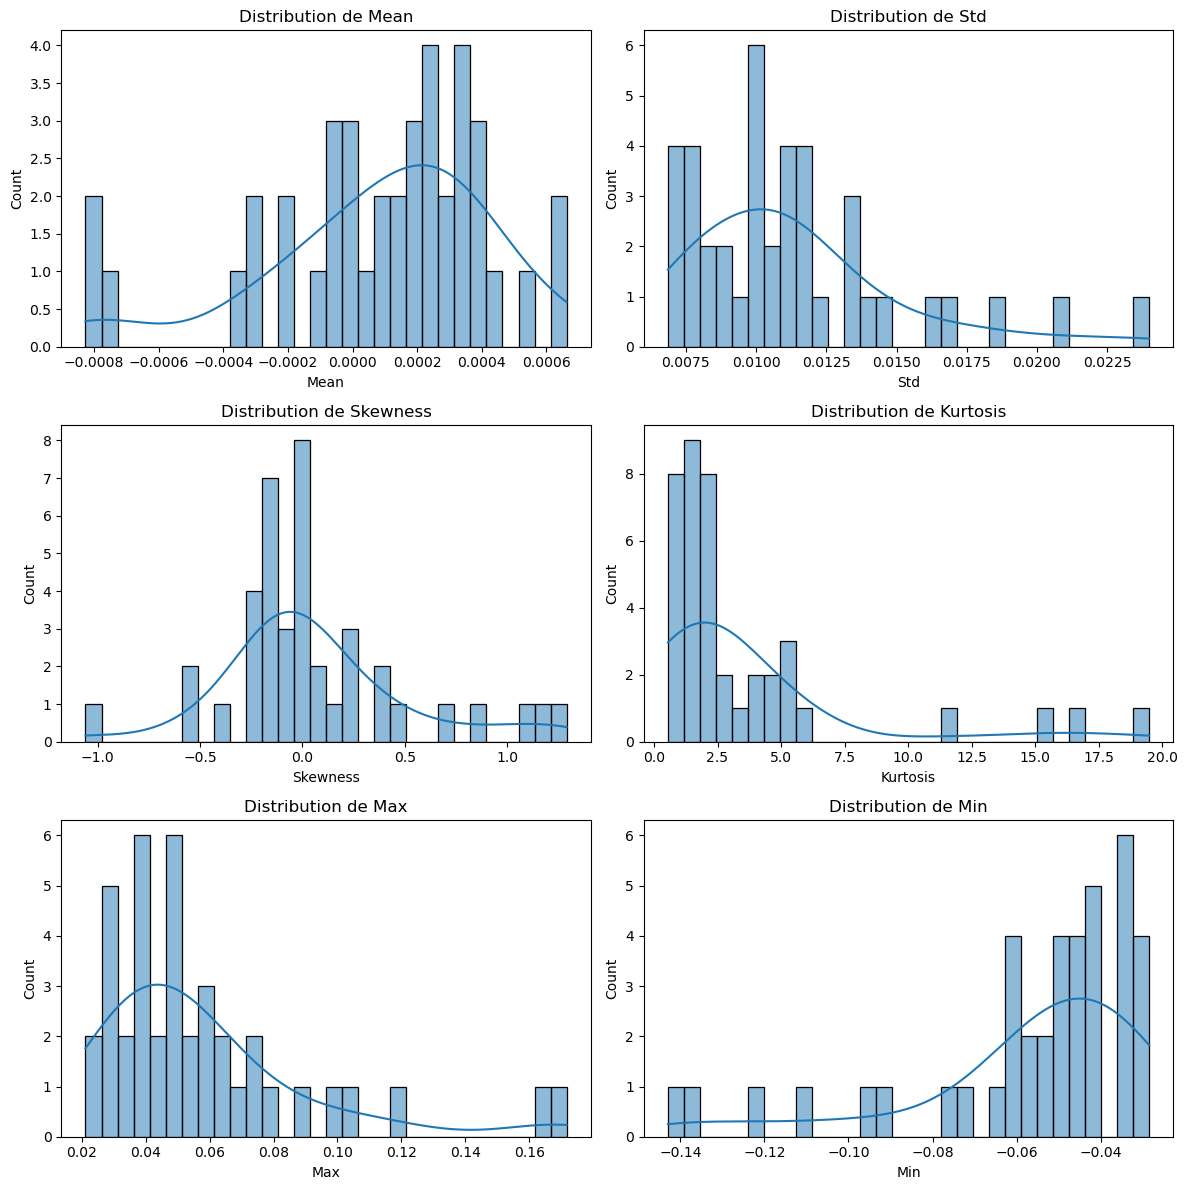

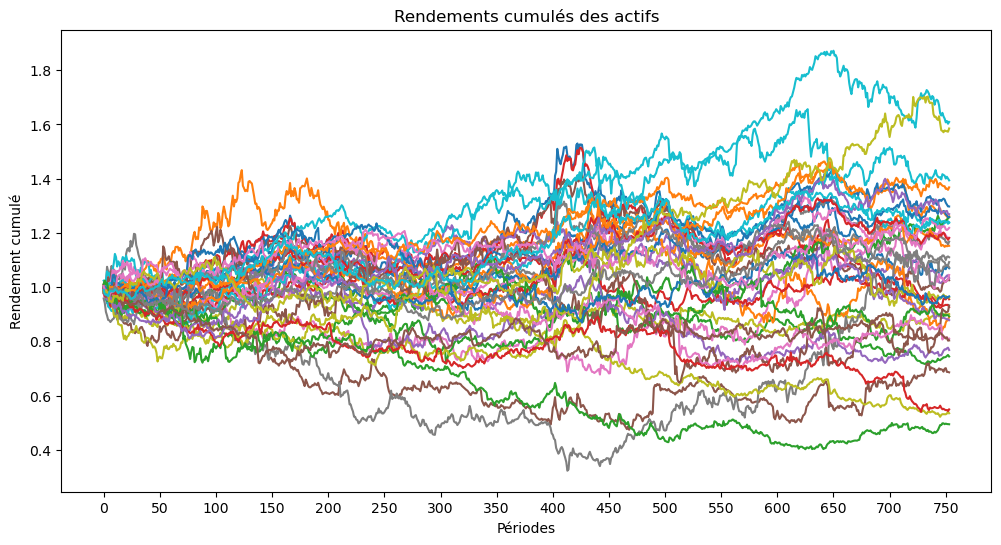

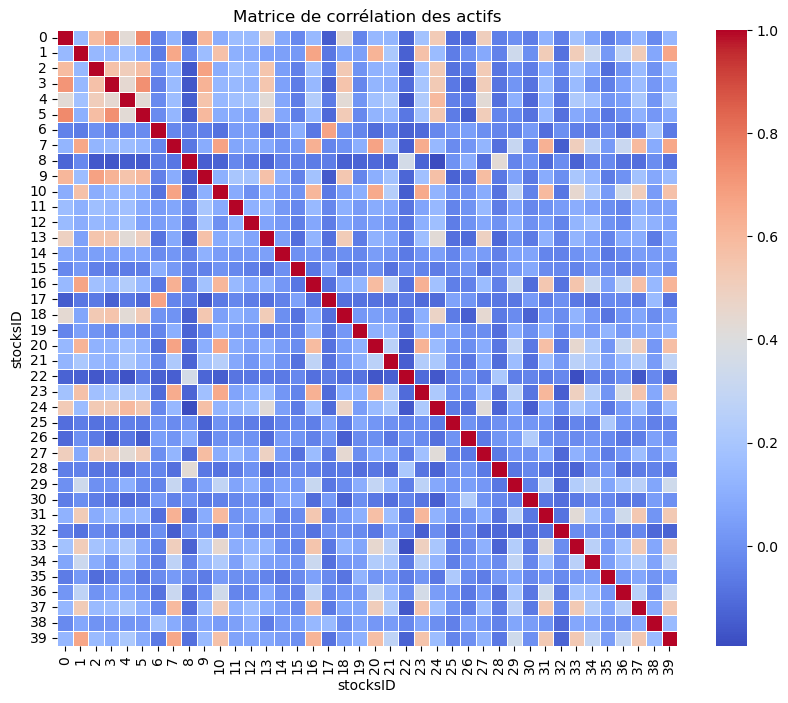

In [4]:
# Analyse statistique des données
stats_df = pd.DataFrame({
    "Mean": X_train.mean(axis=1),
    "Std": X_train.std(axis=1),
    "Skewness": X_train.skew(axis=1),
    "Kurtosis": X_train.kurtosis(axis=1),
    "Max": X_train.max(axis=1),
    "Min": X_train.min(axis=1)
})

print("\nStatistiques des actifs:")
print(stats_df.head())

# Visualisation des distributions des statistiques
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, column in enumerate(stats_df.columns):
    sns.histplot(stats_df[column], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution de {column}")

plt.tight_layout()
plt.show()

# Calcul des rendements cumulés
cumulative_returns = (1 + X_train).cumprod(axis=1)

# Tracé des rendements cumulés
plt.figure(figsize=(12, 6))
for stock in cumulative_returns.index:
    plt.plot(cumulative_returns.columns, cumulative_returns.loc[stock])

plt.xticks(np.arange(0, len(cumulative_returns.columns), step=50))  # Affichage tous les 10 jours
plt.xlabel("Périodes")
plt.ylabel("Rendement cumulé")
plt.title("Rendements cumulés des actifs")
plt.show()

# Calcul de la matrice de corrélation entre les actifs
corr_matrix = X_train.T.corr()

# Plot de la matrice de corrélation en heatmap (sans les chiffres)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)  # annot=False par défaut
plt.title("Matrice de corrélation des actifs")
plt.show()


## Partie II - Méthode de modélisation des facteurs et de la métrique de précision (issues du notebook fourni par le challenge)

In [5]:
# Reshape des données : reconstruit un nouveau dataframe avec les valeurs de X_train décalées de 1 à 250 jours. Chaque ligne represente un actif et une date, et chaque colonne représente un retard.
#Exemple, pour la première ligne on a l'actif 0 (le 1er), au niveau des colonnes, on observe la valeur du rendement en t-1, puis t-2 etc...

X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(future_stack=False) for i in range(250) ], axis =1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag') #Renomme les colonnes pour représenter chaque décalage temporel.

X_test_reshape = pd.concat([ X_test.T.shift(i+1).stack(future_stack=False) for i in range(250) ], axis =1).dropna()
X_test_reshape.columns = pd.Index(range(1,251), name='timeLag') #Renomme les colonnes pour représenter chaque décalage temporel.

# to check the orthonormality constraints as in the metric:
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    #if any(Error.unstack() > 1e-6):
        #bool = False
    max_error = Error.values.max()  # Erreur maximale
    if max_error > 1e-6:
        print(f"⚠️ Problème d'orthonormalité : max error = {max_error:.2e}")
        bool = False
        
    return bool

#Génération des facteurs aléatoires
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return randomStiefel

#Génère un vecteur beta avec m premiers éléments non nuls
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

#Regression lineaire pour ajuster le vecteur beta à partir des facteurs A et des variables cibles Y_train
def fitBeta(A):
    
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack() #Transposition de Y_train et mise sous un format de colonne unique
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    
    return beta.to_numpy()


#Regression lineaire pour ajuster le vecteur beta à partir des facteurs A et des variables cibles Y_train
def fitBeta_with_input(A,X_reshape_input,Y):
    
    predictors = X_reshape_input @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y.T.stack() #Transposition de Y_train et mise sous un format de colonne unique
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    
    return beta.to_numpy()

#Calcul de la métrique
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T #Prédiction avec les facteurs et les beta
    Ytrue = Y_train #Vrai valeurs des rendements
    
    # Normalisation des matrices en divisant chaque valeur par la norme (racine carrée de la somme des carrés).
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    # Nettoyage préventif après normalisation si présence de NaN / infini liés à des divisions proches de zéro
    Ytrue = Ytrue.replace([np.inf, -np.inf], np.nan).fillna(0)
    Ypred = Ypred.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    meanOverlap = (Ytrue * Ypred).sum().mean() #Mesure la similarité entre les prédictions et les vraies valeurs en calculant un produit scalaire moyen.


    return  meanOverlap 


def metric(A, beta, X, Y):
    """
    Calcule la métrique d'alignement
    """
    # Vérification de l'orthonormalité de A
    if not checkOrthonormality(A):
        return -1.0
    
    # Prédiction avec les facteurs et les beta
    Ypred = (X @ A @ beta).unstack().T
    
    # Normalisation des matrices
    Ytrue_norm = Y.div(np.sqrt((Y**2).sum()), axis=1)
    Ypred_norm = Ypred.div(np.sqrt((Ypred**2).sum()), axis=1)

    # Nettoyage préventif après normalisation
    Ytrue_norm = Ytrue_norm.replace([np.inf, -np.inf], np.nan).fillna(0)
    Ypred_norm = Ypred_norm.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Calcul de la métrique d'alignement (produit scalaire moyen)
    meanOverlap = (Ytrue_norm * Ypred_norm).sum().mean()
    
    return Ypred, Ytrue_norm, Ypred_norm, meanOverlap

# Performance et prédiction :

Nous implémentons une fonction de prédiction qui compare les rendements prédits par le modèle à ceux observés, afin de comparer visuellement l’accuracy des modèles.

In [6]:
# Utilise les facteurs A et le vecteur beta pour prédire les rendements futurs et évalue les performances du modèle.
def predict_and_evaluate_avec_normalisation(A,Y,X_reshape_input,istrain:bool=True):

    beta = fitBeta_with_input(A,X_reshape_input,Y)  # Régression linéaire pour ajuster beta

    # Calcul des métriques
    Ypred, Ytrue_norm, Ypred_norm, meanOverlap = metric(A, beta, X_reshape_input, Y)  # Calcul de la métrique
    mse = mean_squared_error(Y.values.flatten(), Ypred.values.flatten())
    correlation = np.corrcoef(Y.values.flatten(), Ypred.values.flatten())[0, 1]
    if np.isnan(correlation):
        print("⚠️ Attention : Corrélation non définie (valeurs constantes ou NaN).")

    if istrain:
        titre ="jeu d'entrainement"
    else:
        titre ="jeu de test"

    print(f"📊 Performance du modèle sur {titre} :")
    print(f"✅ Valeur de la metrique : {meanOverlap:.6f}")
    print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
    print(f"✅ Racine de l'erreur quadratique moyenne (RMSE) : {np.sqrt(mse):.6f}")
    print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

    # Plot 1 : Moyenne des valeurs prédites vs vraies valeurs (normalisées)
    plt.figure(figsize=(10, 5))
    plt.plot(Y.columns, Ytrue_norm.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
    plt.plot(Y.columns, Ypred_norm.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
    plt.xlabel("Jours après 250")
    plt.ylabel("Rendement normalisé moyen")
    plt.title(f"Comparaison des rendements normalisés du {titre} : Réels vs Prédits")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot 2 : Histogramme des erreurs (inchangé)
    errors = (Ypred - Y).values.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
    plt.ylabel("Fréquence")
    plt.title(f"Distribution des erreurs de prédiction du {titre}")
    plt.grid()
    plt.show()

    # Plot 3 : Rendements cumulés normalisés (au lieu des valeurs brutes)
    plt.figure(figsize=(10, 5))
    
    cumulative_real = (1 + Ytrue_norm.mean(axis=0)).cumprod() - 1
    cumulative_pred = (1 + Ypred_norm.mean(axis=0)).cumprod() - 1

    plt.plot(Y_train.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
    plt.plot(Y_train.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
    plt.xlabel("Jours après 250")
    plt.ylabel("Rendement cumulé normalisé moyen")
    plt.title(f"Comparaison des rendements cumulés normalisés du {titre} : Réels vs Prédits")
    plt.legend()
    plt.grid()
    plt.show()

    return mse, correlation


# Affiche, pour chaque actif, son rendement cumulé réel (ligne continue)et prédit (ligne pointillée) dans des sous-graphiques organisés en 5x2.
def plot_cumulative_returns_per_asset(Y_test, Ytrue, Ypred):

    # Pré-néttoyage potentiel
    Ytrue = Ytrue.dropna()
    Ypred = Ypred.dropna()

    n_assets = len(Y_test.index)
    
    # On prévoit un maximum de 10 sous-graphiques (5 lignes x 2 colonnes).
    # Si vous avez plus de 10 actifs, seuls les 10 premiers seront tracés.
    # Ajustez si nécessaire.
    max_plots = 10  
    n_plots = min(n_assets, max_plots)
    
    # Création de la figure et de la grille de sous-plots
    # sharex=False, sharey=False => chaque subplot a sa propre échelle
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 18),
                             sharex=False, sharey=False)
    axes = axes.flatten()  # Pour itérer facilement

    # Palette de couleurs
    colors = plt.cm.tab10(np.linspace(0, 1, n_plots))
    
    for i, asset in enumerate(Y_test.index[:n_plots]):
        ax = axes[i]
        
        # Calcul du rendement cumulé pour l'actif (réel et prédit)
        cumulative_real = (1 + Ytrue.loc[asset]).cumprod() - 1
        cumulative_pred = (1 + Ypred.loc[asset]).cumprod() - 1
        
        # Tracé avec la même couleur : ligne continue pour le réel, pointillée pour la prédiction
        ax.plot(Y_test.columns, cumulative_real, color=colors[i], linestyle='-', label="Réel")
        ax.plot(Y_test.columns, cumulative_pred, color=colors[i], linestyle='--', label="Prédit")
        
        ax.set_title(f"Actif : {asset}")
        ax.grid(True)
        ax.legend()
    
    # On supprime les sous-plots inutilisés s'il y a moins de 10 actifs
    for j in range(n_plots, 10):
        fig.delaxes(axes[j])
    
    fig.suptitle("Rendements cumulés normalisés par actif", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Laisse de la place pour le titre global
    plt.show()


## Benchmark de construction de facteurs et d'analyse de métrique

Facteurs générés de manière aléatoire 1000 fois, puis sélection des facteurs offrant la meilleure métrique. Cette approche sert de référence (benchmark) pour le modèle à implémenter.

0 metric_train: 0.03498249220188183
1 metric_train: 0.04175985816755471
31 metric_train: 0.046116712839033555
91 metric_train: 0.04933169735239696
421 metric_train: 0.05108624733831952
496 metric_train: 0.05151010749740387
675 metric_train: 0.05454273855058289
📊 Performance du modèle sur jeu d'entrainement :
✅ Valeur de la metrique : 0.054543
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.012121
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0592


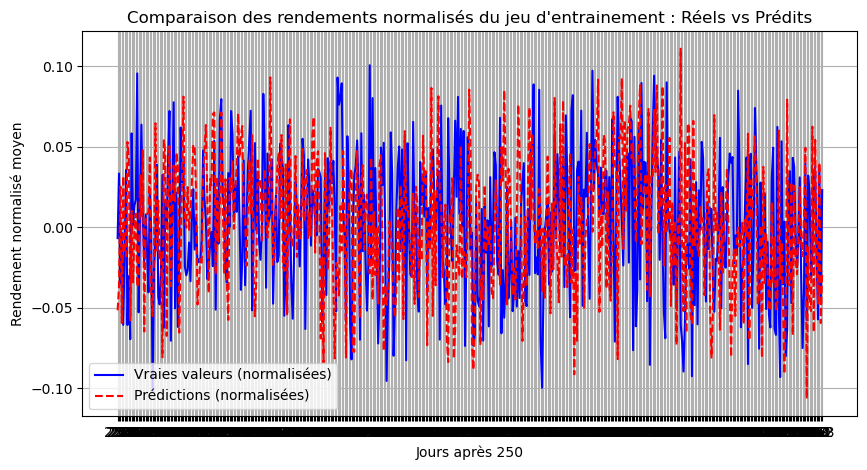

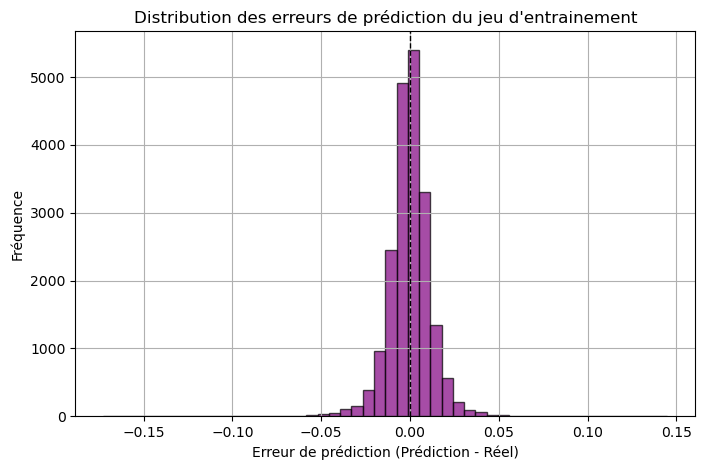

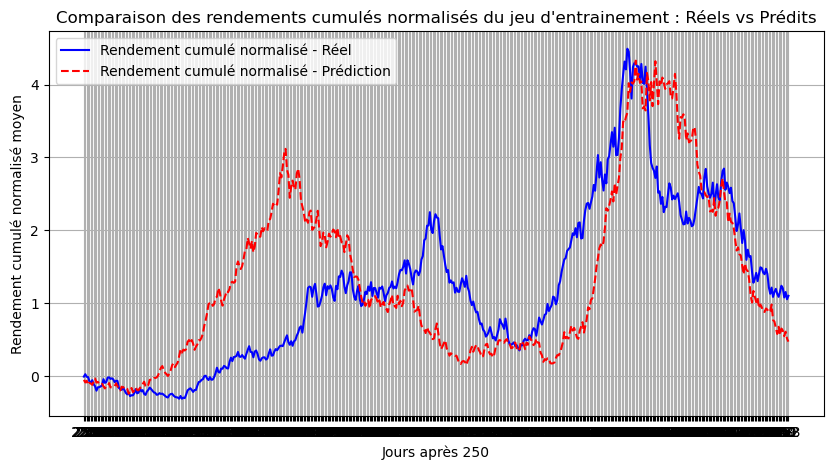

📊 Performance du modèle sur jeu de test :
✅ Valeur de la metrique : 0.047632
✅ Erreur quadratique moyenne (MSE) : 0.000221
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.014873
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0515


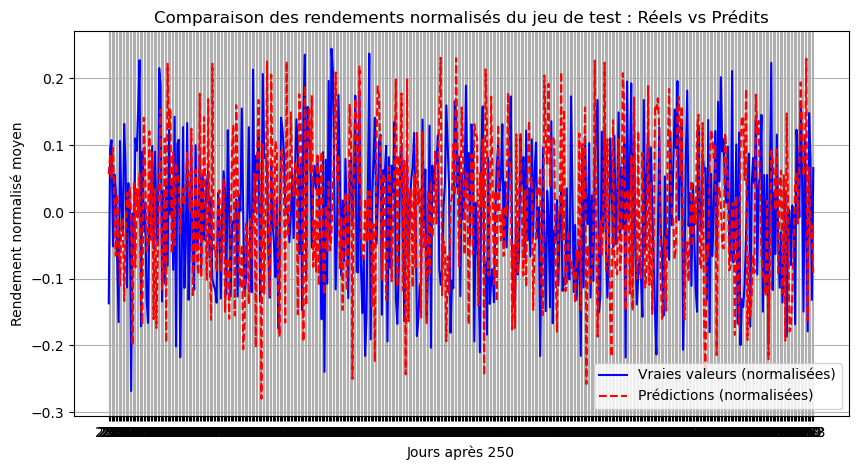

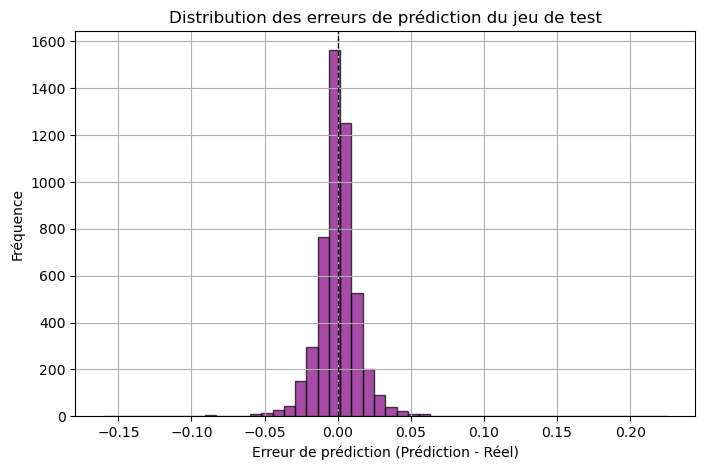

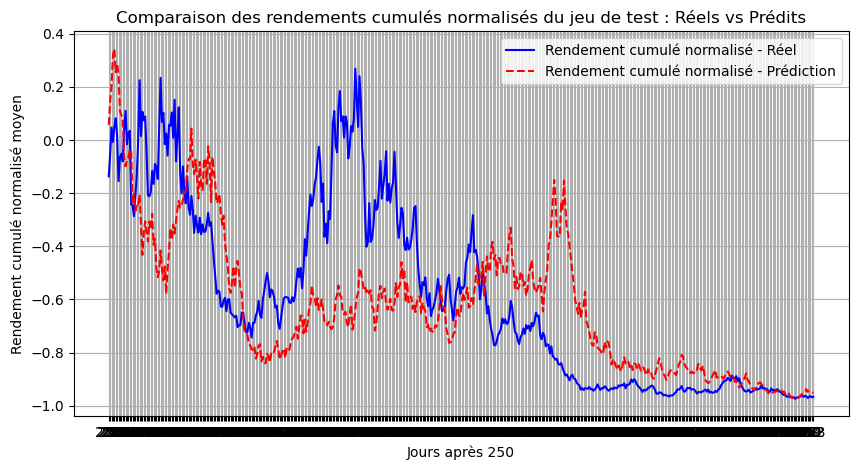

In [7]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = randomA()
    beta = fitBeta(A) # A partir des facrtors générés aléatoirement, il va prendre pour chaque point de données, les 250 données précédement formaté a partir de X_reshape et va faire une regression linéaire pour prédire les rendements futurs.
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  

# Evaluation du modèle sur le jeu de train
mse, correlation = predict_and_evaluate_avec_normalisation(A_QRT, Y_train,X_train_reshape,istrain=True) 

# Evaluation du modèle sur le jeu de test
mse, correlation = predict_and_evaluate_avec_normalisation(A_QRT, Y_test, X_test_reshape,istrain=False) 


Globalement, les prédictions basées sur l'approche de facteurs générés aléatoirement et rendu orthonormalisés échouent naturellement à capturer les dynamiques du marché. En effet, la structure aléatoire des facteurs ne permet ni de capter les signaux financiers, ni de modéliser le bruit observé sur les marchés.

## Partie III - Analyse d'un modèle de régression ajusté à partir de facteurs financiers issus de la littérature


Nous travaillons sur des rendements financiers et avons sélectionné des features classiques issues de la littérature financière :

- **Momentum** : rendement cumulé sur une fenêtre déterminée, qui mesure la tendance d'un actif.
- **Volatility** : écart-type annualisé des rendements sur une période donnée, indicateur de risque.
- **Moving average** : moyenne mobile des rendements, utile pour lisser les variations et identifier des tendances.
- **RSI (Relative Strength Index)** : indicateur de surachat ou de survente basé sur la force relative des gains et pertes récents.


Une fois calculés, ces indicateurs sont normalisés (sous forme de z-scores) afin d’être comparables d’un actif à l’autre. L’idée est de capter, pour chaque date, un signal moyen à partir de l’ensemble des actifs : on agrège donc les z-scores de chacun de ces indicateurs pour obtenir un facteur commun (par exemple un « facteur momentum » global, un « facteur volatilité », etc.).

Ensuite, on assure l’orthonormalité de ces facteurs. Autrement dit, on les transforme de sorte qu’ils soient entre eux aussi indépendants que possible, de façon à éviter qu’un même signal soit mesuré deux fois. Lorsque plus de facteurs sont souhaités, on complète la matrice en générant des colonnes supplémentaires aléatoires, puis on orthonormalise à nouveau. Cette étape assure que chaque facteur capte une dimension spécifique du marché, sans redondance.

Enfin, le modèle linéaire est ajusté : pour chaque actif et chaque date, on estime un vecteur de coefficients (
𝛽
β) traduisant la sensibilité des rendements à ces facteurs. On évalue ensuite la capacité du modèle à expliquer ou prédire les rendements observés via la métrique.


📊 Performance du modèle sur jeu d'entrainement :
✅ Valeur de la metrique : 0.027556
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.012137
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0286


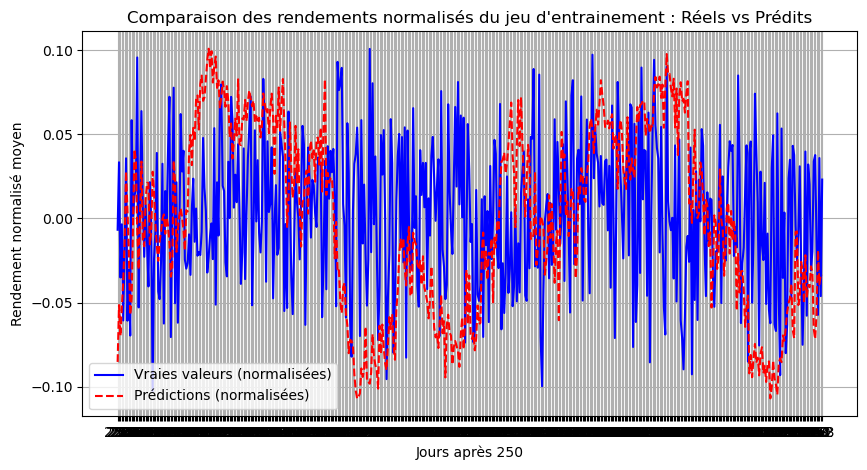

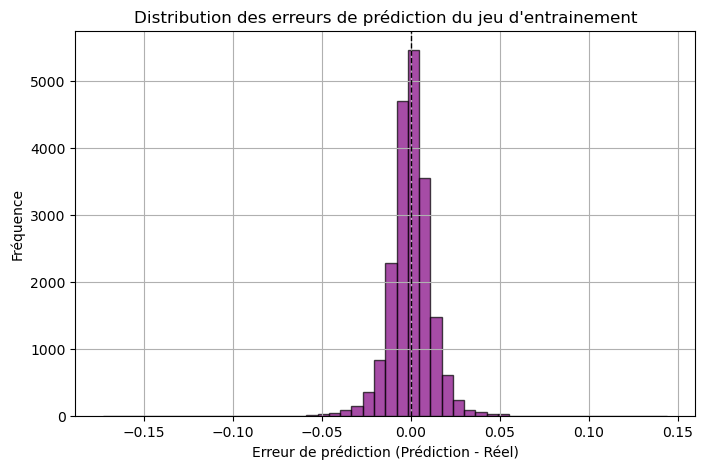

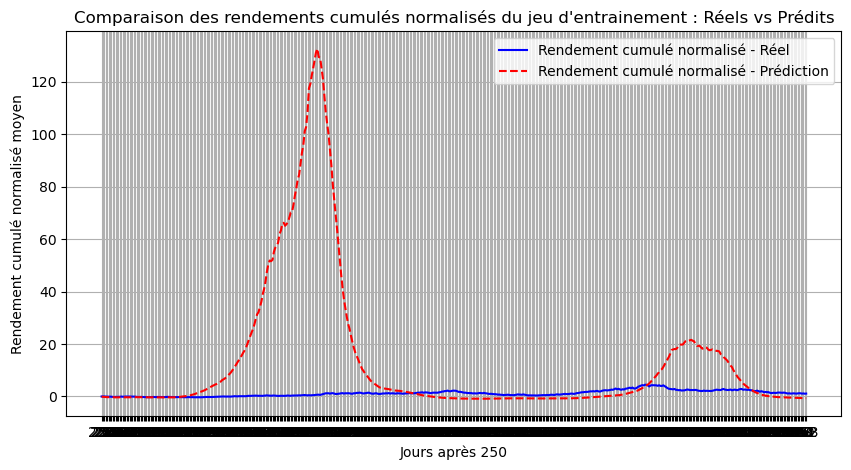

📊 Performance du modèle sur jeu de test :
✅ Valeur de la metrique : 0.014864
✅ Erreur quadratique moyenne (MSE) : 0.000222
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.014890
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0179


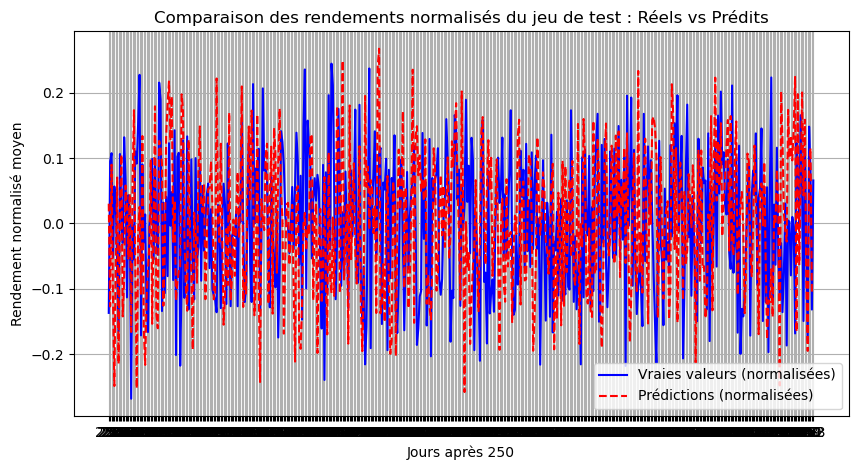

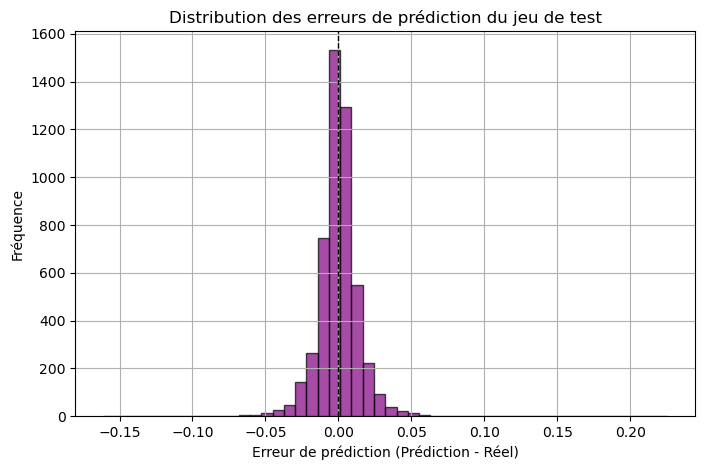

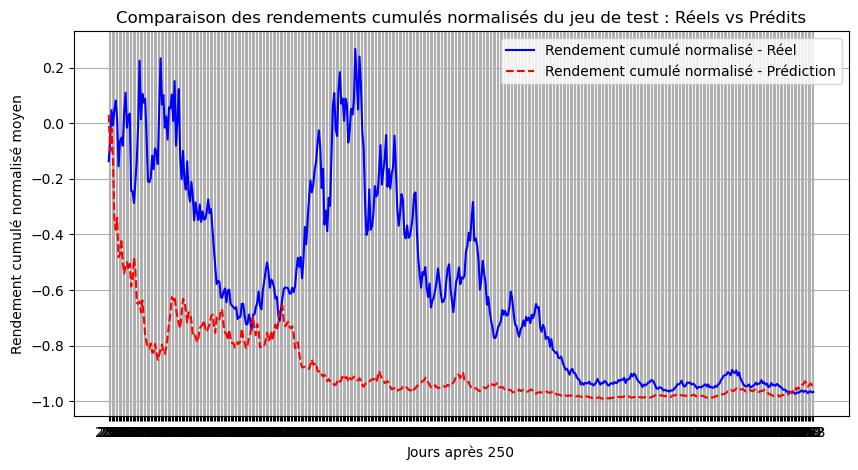

In [8]:

def compute_momentum(returns, window=21):
    """ Calcule le momentum comme rendement cumulé sur la période donnée """
    return returns.rolling(window=window).sum()

def compute_volatility(returns, window=21):
    """ Calcule la volatilité réalisée """
    return returns.rolling(window=window).std()

def compute_moving_average(price, window=21):
    """ Calcule la moyenne mobile """
    ma = price.rolling(window=window).mean()
    return price - ma

def compute_rsi(price, window=14):
    """ Calcule l'indicateur RSI, indicateur de surachat ou de suvente """
    delta = price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() #Moyenne des rendements positifs (gains)
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean() #Moyenne des rendement negatifs (pertes)
    rs = gain / loss
    return 100 - (100 / (1 + rs)) #Transformation du rs en score RSI (plus il est important plus c'est un signe de surachat et inversement)

def compute_z_score(series):
    """Calcule le z-score pour chaque série"""
    return (series - series.mean()) / series.std()


def generate_features(X_train):
    """ Génère les features et calcule un facteur unique pour chaque date """
    feature_dict = {}
    
    # Calcul des caractéristiques pour chaque actif
    for col in X_train.columns:

        # Calcul des caractéristiques : momentum, volatilité, moyenne mobile, et RSI
        feature_dict[f'momentum_{col}'] = compute_momentum(X_train[col])
        feature_dict[f'volatility_{col}'] = compute_volatility(X_train[col])
        feature_dict[f'moving_avg_{col}'] = compute_moving_average(X_train[col])
        feature_dict[f'rsi_{col}'] = compute_rsi(X_train[col])

    features = pd.concat(feature_dict, axis=1)  # On concatène tout en une seule fois
    
    # Calcul des z-scores pour chaque caractéristique sur tous les actifs à chaque date
    features_z = features.apply(compute_z_score, axis=0)  # Normalisation

    # Maintenant, pour chaque date, on calcule un facteur global (moyenne des z-scores)
    # pour chaque caractéristique
    factor_momentum = features_z.filter(like="momentum").mean(axis=1)  # Moyenne des z-scores du momentum
    factor_volatility = features_z.filter(like="volatility").mean(axis=1)  # Moyenne des z-scores de la volatilité
    factor_moving_avg = features_z.filter(like="moving_avg").mean(axis=1)  # Moyenne des z-scores de la moyenne mobile
    factor_rsi = features_z.filter(like="rsi").mean(axis=1)  # Moyenne des z-scores du RSI

    # DataFrame final avec un facteur pour chaque caractéristique à chaque date
    final_features = pd.DataFrame({
        'momentum_factor': factor_momentum,
        'volatility_factor': factor_volatility,
        'moving_avg_factor': factor_moving_avg,
        'rsi_factor': factor_rsi
    })
    
    # Garde seulement les 250 premières dates
    final_features = final_features.fillna(0)
    final_features = final_features.iloc[:250]
    
    return final_features

def A_Factors(D=250, F=10):
    factors = generate_features(X_train.T).values 
    
    # On normalise les 4 facteurs pour qu'ils soient orthonormaux
    A = np.zeros((D, F))
    for i in range(4):
        A[:, i] = factors[:, i] / np.linalg.norm(factors[:, i])

    A[:, :4] = scipy.linalg.orth(A[:, :4]) # Assure l'orthonormalité
    
    if F<=4:
        return A
    
    # # # Génération des 6 autres colonnes orthonormales
    orthoProj = np.eye(D)
    for i in range(4):
        orthoProj -= np.outer(A[:, i], A[:, i])
    
    A_remaining_columns = orthoProj @ np.random.randn(D, F - 4)
    A_remaining_columns = scipy.linalg.orth(A_remaining_columns)  # Orthonormalisation

    A[:, 4:] = A_remaining_columns
    return A

A = A_Factors(F=4)  # Génération des facteurs A avec nos 4 indicateurs seulement

# Evaluation du modèle sur le jeu de train
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape) 

# Evaluation du modèle sur le jeu de test
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,istrain=False) 

Résultats pauvres en performance de métrique (0,012) mais également en terme de valeurs prédites par le modèle de regression notamment sur le jeu de train. Les prédictions tendent à donner des résultats avec une échelle bien plus grande par rapport aux valeurs des rendements attendus, néanmoins, la prédiction pour le jeu de test s'améliore sans pour autant présenter des résultats nous permettant de retenir l'approche par rapport au benchmark aléatoire de QRT.

## Approche combinatoire avec nos 4 facteurs et F-4 autres randomisés et rendus orthonormalisés (processus du challenge)

Résultats pour 9 facteurs :
0 metric_train: 0.03294477617228363
1 metric_train: 0.040826249056191435
3 metric_train: 0.043115836656640656
12 metric_train: 0.0539452951221282
502 metric_train: 0.05675800948361467
Résultats pour 10 facteurs :
469 metric_train: 0.057023770381898216
Résultats pour 11 facteurs :
📊 Performance du modèle sur jeu d'entrainement :
✅ Valeur de la metrique : 0.057024
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.012123
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0557


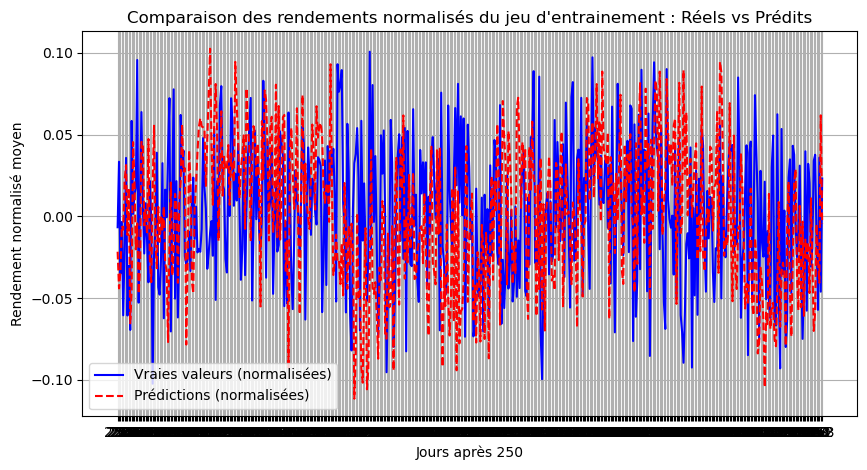

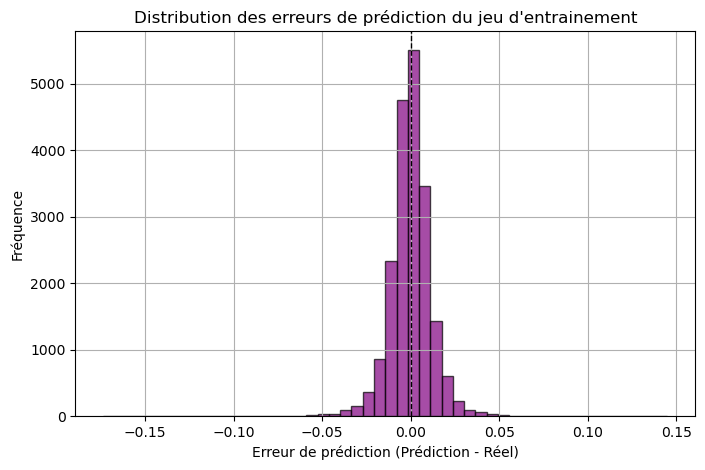

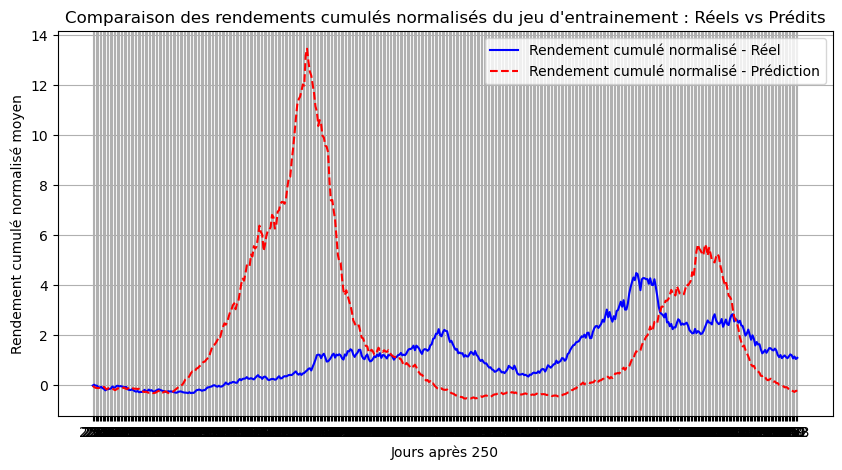

📊 Performance du modèle sur jeu de test :
✅ Valeur de la metrique : 0.046540
✅ Erreur quadratique moyenne (MSE) : 0.000221
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.014881
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0399


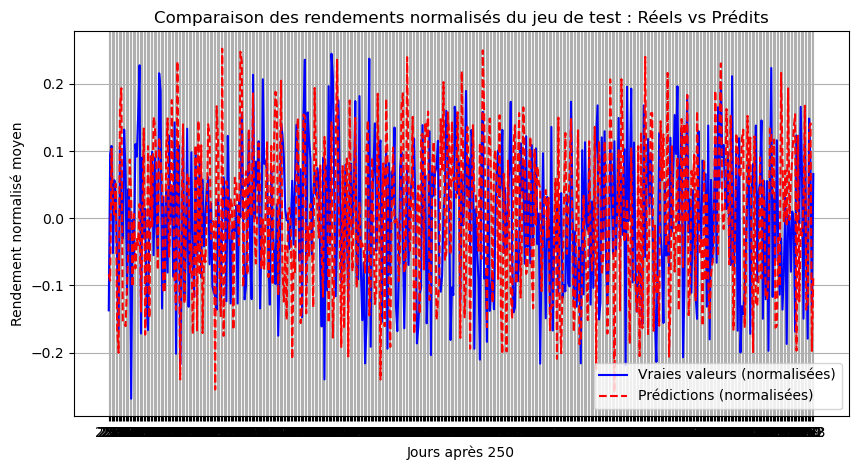

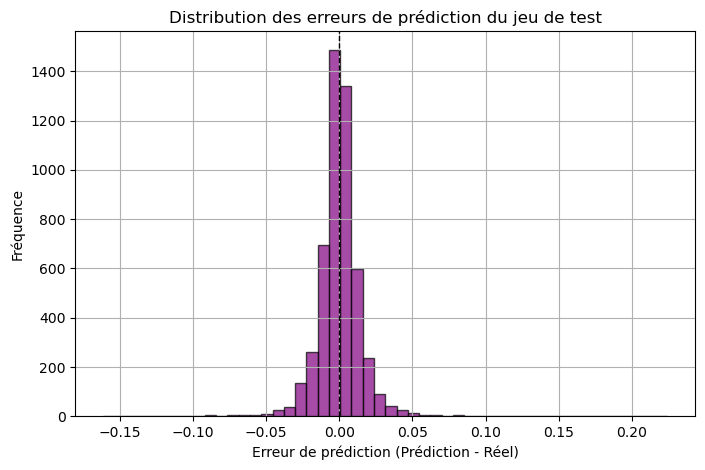

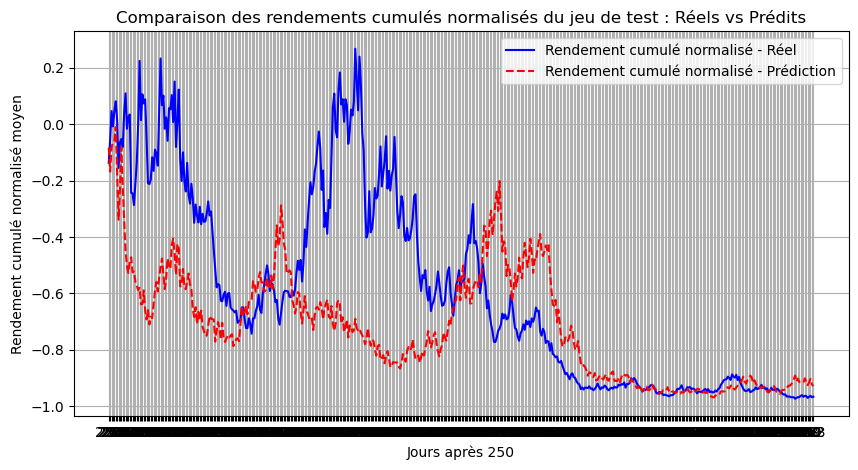

In [9]:
# En générant aléatoirement de 9 à 12 facteurs pour 1000 itérations successives
# Approche entre 9 à 12 facteurs, moins donnant systématiquement un metric score inférieur au benchmark
Niter = 600
maxMetric = -1

np.random.seed(1234)

for factor_i in range(9,12):
    print(f"Résultats pour {factor_i} facteurs :")

    for iteration in range(Niter):
        
        A = A_Factors(F=factor_i)
        beta = fitBeta(A)
        m = metric_train(A, beta)
            
        if m > maxMetric:
            print(iteration, 'metric_train:', m)
            
            maxMetric = m
            A_opt = A
            beta_opt = beta
            factor_opt = factor_i

# Evaluation sur le set d'entrainement
mse, correlation = predict_and_evaluate_avec_normalisation(A_opt, Y_train,X_train_reshape)

# Evaluation sur le set de test
mse, correlation = predict_and_evaluate_avec_normalisation(A_opt, Y_test,X_test_reshape,istrain=False)

Les résultats présentés ci-dessus donnent une performance de métrique améliorée mais peinent à capturer les tendances nettes des rendements à des niveaux locaux, cependant lorsque les rendements cumulés semblent se stationnariser, le modèle améliore sa prédiction. De façon cohérente, plus nous ajoutons de l'information (plus de vecteurs de facteurs), plus le modèle améliore sa prédiction. Plus généralement, le bruit présent au niveau des données des séries financières et relations non linéaires ne peuvent pas être correctement capturé à l'aide de modèle de regression linéaire. Il pourra donc être intéressant d'observer d'autres approches non linéaires qui sera l'objet des parties suivantes.

## Partie IV : Modèle non supervisé (clustering)

- Une telle approche pourrait éventuellement capturer différents régimes de marché et certaines tendances plus locales comme évoqués précédemment avec les concepts de distance euclidienne & centroîds relatifs par exemple.
- Réduction de dimension des facteurs en conservant l'information principale et non redondantes avec PCA.
- Détermination du meilleur K avec la méthode du coude :
    Analyser l'évolution de l'inertie intra-classe en fonction du nombre de cluster. L'algoritmhe va partionner un ensemble de point en K groupes jusqu'a ce qu'un certain seuil de minimisation de l'inertie intra classe.
    L’inertie diminue forcément quand on augmente 𝐾, mais après un certain point, l'amélioration devient négligeable. Le "coude" est ce point optimal où l'ajout de clusters ne réduit plus significativement l'inertie.




- Application du clustering K-Means.
- Évaluation et ajustement des hyperparamètres (optimisation avec GridSearchCV).

In [10]:

def find_optimal_k_elbow(X, max_k=500):
    """Utilise la méthode du coude pour déterminer le nombre optimal de clusters."""
    
    inertias = [] #Vecteur pour stocker les valeurs d'inertie
    k_values = range(1, max_k + 1) #Valeurs de K à tester
    
    #Boucle sur les valeurs de K pour calculer l'inertie
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Exécute KMeans avec K clusters  et 10 initialisations des centroides et choisit la meilleure solution
        kmeans.fit(X)  # # Entraine le modèle sur les données de X
        inertias.append(kmeans.inertia_) #Stocke la valeur de l'inertie associé à k
    
     # courbe du coude
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Inertie (SSE)')
    plt.title('Méthode du coude pour déterminer K')
    plt.grid(True)
    plt.show()
    
     # Demande à l'utilisateur de choisir K, en fonction du point optimal sur le graphique, le "coude" ou la courbe commence à s'aplatir
    k_optimal = int(input("Veuillez entrer la valeur optimale de K en fonction du graphique : "))
    #k_optimal =20
    return k_optimal

def apply_kmeans(X, k):
    """Applique K-Means et retourne les labels et le modèle KMeans."""
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Initialisation du modèle KMeans
    labels = kmeans.fit_predict(X)   #entrainement du modèle et attribution des valeurs à des clusters (labels)
    return labels, kmeans

def optimize_clustering(X_train, best_k):
    """Optimise K-Means avec validation croisée manuelle et retourne le meilleur modèle."""
    
    param_grid = {'n_clusters': [best_k-1, best_k, best_k+1], 'init': ['k-means++', 'random']}
    
    best_inertia = np.inf  
    best_model = None  

    # # Validation croisée manuelle avec KFold (3 folds ici, c'est a dire qu'on divise le dataset en 3, pour entrainer sur 2 folds et tester sur la 3eme)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    #Boucle pour parcourir chaque Hyperparamètres
    for n_clusters in param_grid['n_clusters']: #Parcours la liste de nombre de clusters qu'on souhaite tester (best_k-1, best_k, best_k+1)
        for init_method in param_grid['init']:#Parcours la liste des méthodes d'initialisation des centroides ('k-means++', 'random')
            avg_inertia = 0   # Initialisation de la variable d'inertie moyenne pour ces paramètres

            # Boucle sur les splits de la validation croisée
            for train_idx, test_idx in kf.split(X_train):
                X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx] # Sépare les données en train et test
                model = KMeans(n_clusters=n_clusters, init=init_method, random_state=42, n_init=10) #modèle KMeans avec les paramètres de le boucle
                model.fit(X_train_fold)   #Entrainement du modèle sur le jeu d'entrainement
                avg_inertia += model.inertia_   # Évalue l'inertie sur le jeu de test

            avg_inertia /= kf.get_n_splits()   # Moyenne des inerties sur tous les splits

            # Si l'inertie moyenne est meilleure (plus faible), on garde ce modèle
            if avg_inertia < best_inertia:
                best_inertia = avg_inertia
                best_model = model

    print(f"Meilleur modèle K-Means trouvé avec K={best_model.n_clusters} et init='{best_model.init}'")
    return best_model

def generate_factors_from_clusters(X_pca, best_cluster_model):
    """
    Génère la matrice A (250 jours, n_clusters) en utilisant les distances aux centroïdes.
    """
    centroids = best_cluster_model.cluster_centers_  # (n_clusters, d)


    X_pca = np.array(X_pca)  # Assure que c'est bien un tableau NumPy

    # Vérification que les dimensions sont bien alignées
    if X_pca.shape[1] != centroids.shape[1]:
        raise ValueError(f"Incompatibilité des dimensions : X_pca={X_pca.shape}, centroids={centroids.shape}")

    # Calcul des distances correctement alignées
    distances = np.linalg.norm(X_pca[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)  

    # Extraction des 250 premières lignes (jours)
    A = distances[:250, :]  # (250, n_clusters)

    A, _ = np.linalg.qr(A)  # Q est une matrice orthonormale

    return A

def compute_OLS(X_train, Y_train,features):
    predictors = X_train @ features
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    return beta.to_numpy()


def launch_clustering_model(X_train,best_k=None):
    
    # 1. Réduction de dimension avec PCA pour X_train.T (taille initiale (50, 754))
    pca = PCA(n_components=0.95)  
    x_pca = pca.fit_transform(X_train.T) 
    x_pca, _ = np.linalg.qr(x_pca)

    # 2. Trouver K optimal
    if best_k is None :best_k = find_optimal_k_elbow(x_pca)

    # 3. Optimiser K-Means avec validation croisée
    best_cluster_model = optimize_clustering(x_pca, best_k)

    # 4. Générer la matrice A (250 jours, n_clusters)
    A = generate_factors_from_clusters(x_pca, best_cluster_model)

    return A,best_k



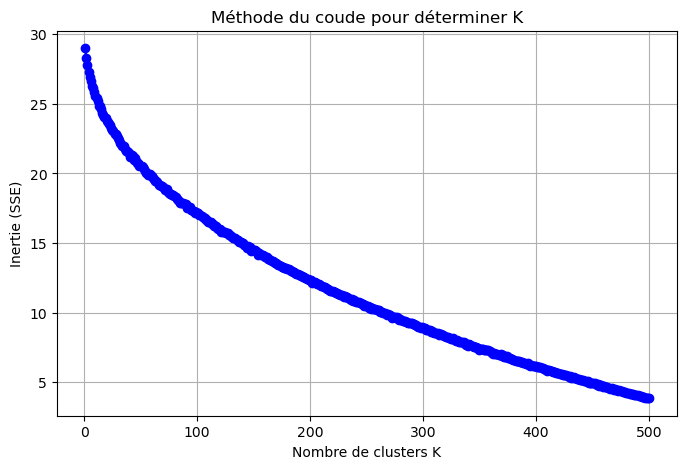

Meilleur modèle K-Means trouvé avec K=201 et init='k-means++'
📊 Performance du modèle sur jeu d'entrainement :
✅ Valeur de la metrique : 0.138931
✅ Erreur quadratique moyenne (MSE) : 0.000144
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.012001
✅ Corrélation entre les prédictions et les vraies valeurs : 0.1517


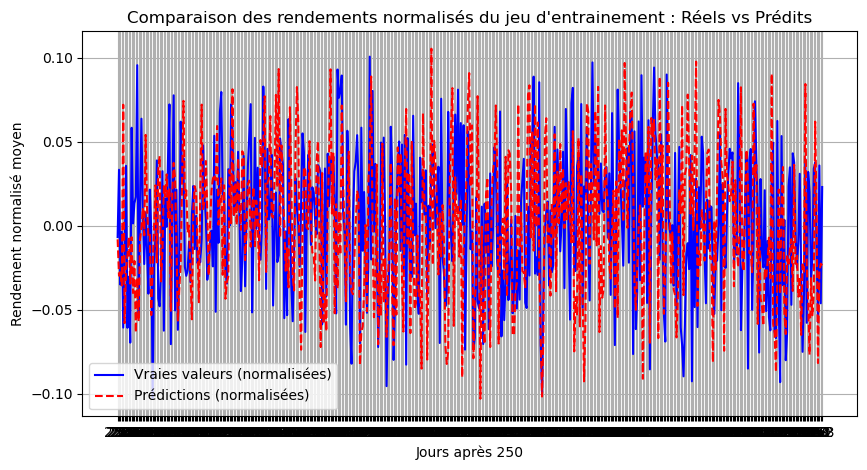

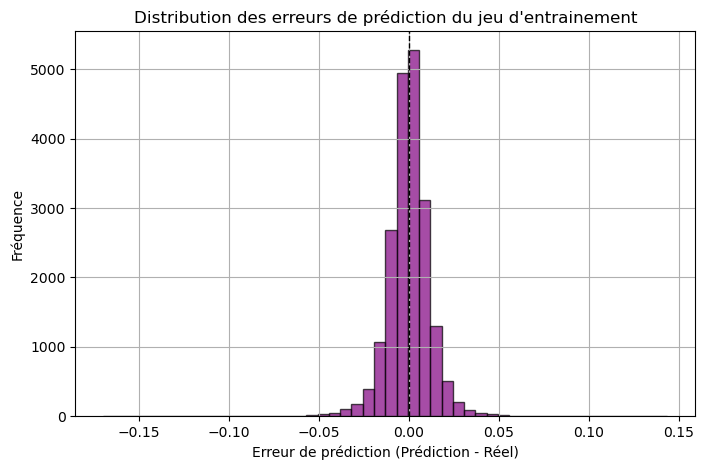

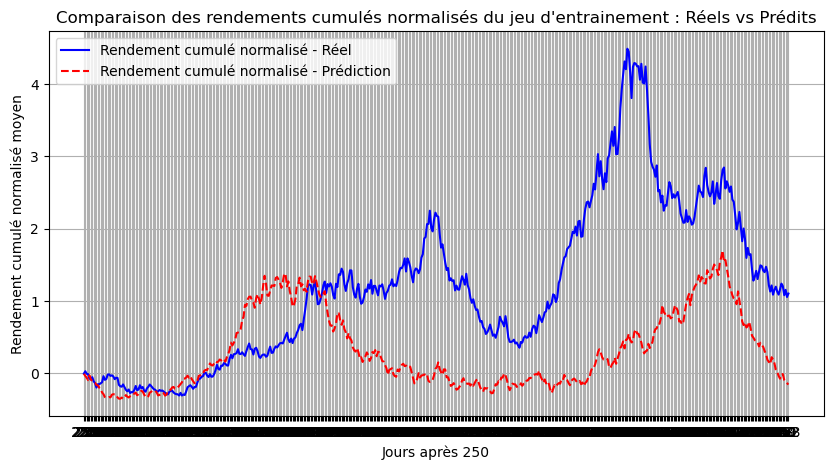

📊 Performance du modèle sur jeu de test :
✅ Valeur de la metrique : 0.197938
✅ Erreur quadratique moyenne (MSE) : 0.000208
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.014410
✅ Corrélation entre les prédictions et les vraies valeurs : 0.2526


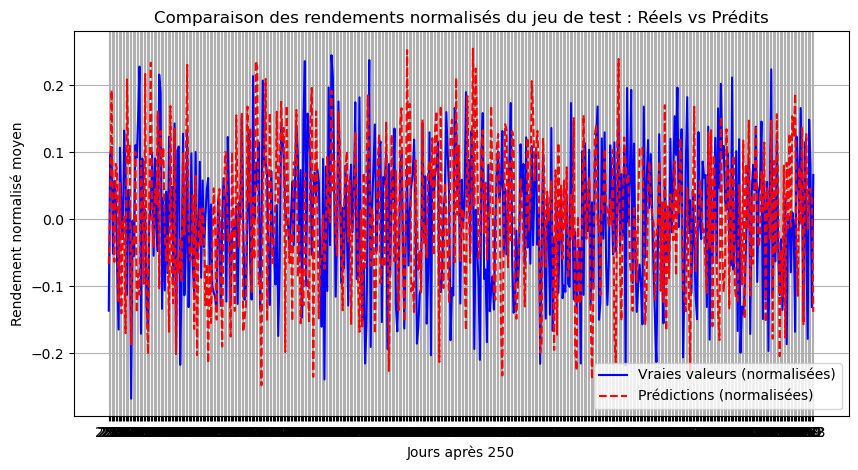

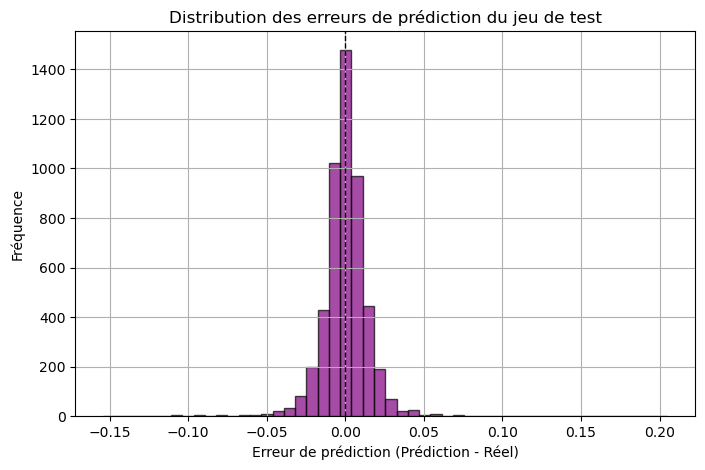

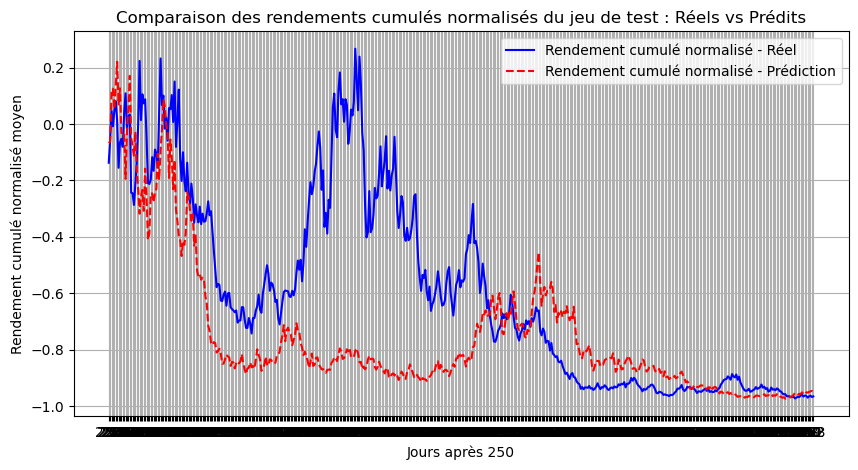

In [12]:
#Lancement du clustering model
A,best_k = launch_clustering_model(X_train)

# Evaluation du modèle sur le jeu de train
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape) 

# Evaluation du modèle sur le jeu de test
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,istrain=False) 


La méthode K-Means échoue à la prévision des rendements financiers car elle est conçue pour segmenter des données en groupes homogènes et non pour prédire des valeurs futures. Cette méthode minimise la variance intra-cluster, ce qui suppose implicitement que les clusters sont sphériques et de tailles similaires. Or, les rendements financiers sont hautement volatils et bruités, ce qui empêche une séparation claire en groupes distincts. Ainsi, K-Means ne parvient pas à capturer les dynamiques de marché et à produire des facteurs pertinents pour la prédiction.

## Alternative dans le bloc de code en dessous mais résultats pas ouf (+ j'ai pas trop vérifié c'qui se passait réellement et la pertinence, pas sûr qu'on garde)

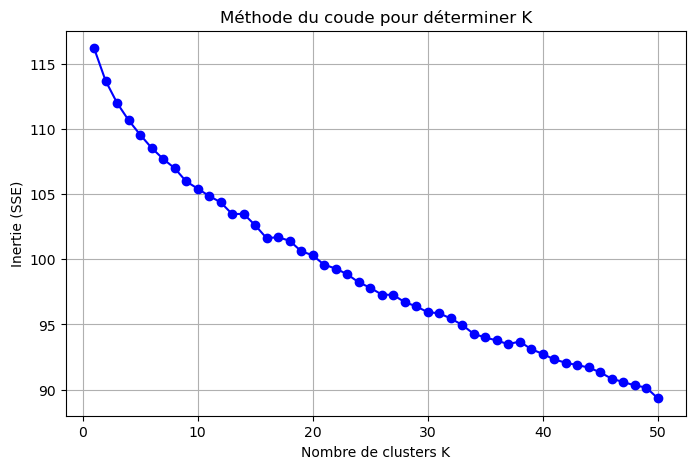

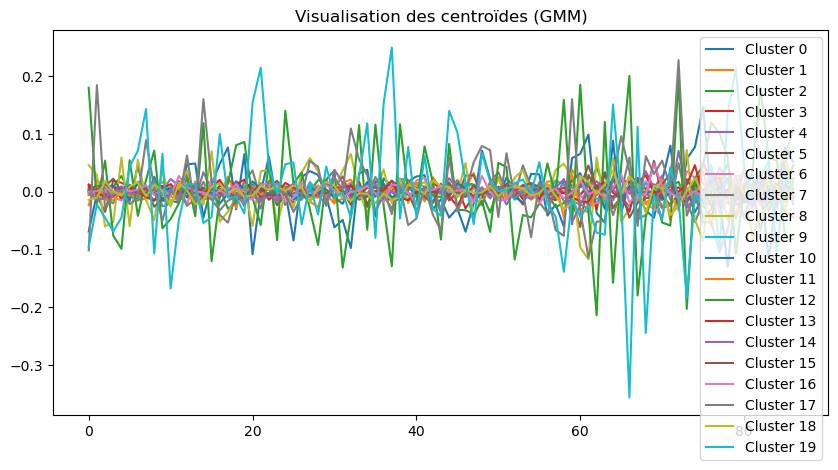

📊 Performance du modèle sur jeu d'entrainement :
✅ Valeur de la metrique : 0.034526
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.012131
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0419


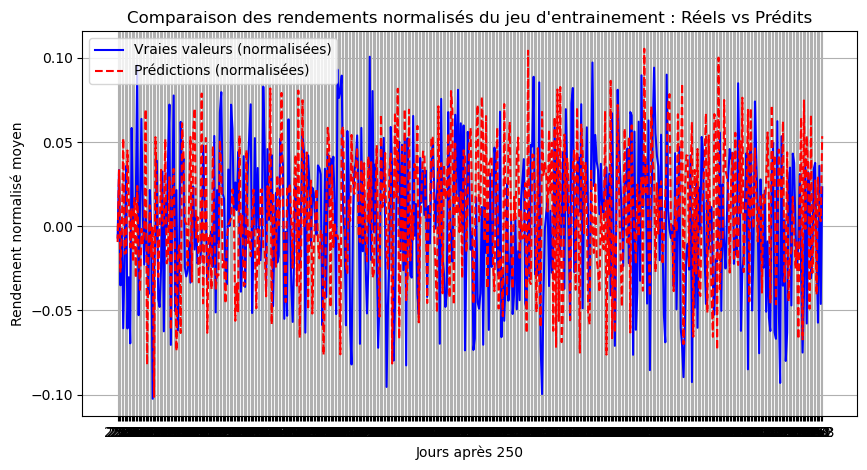

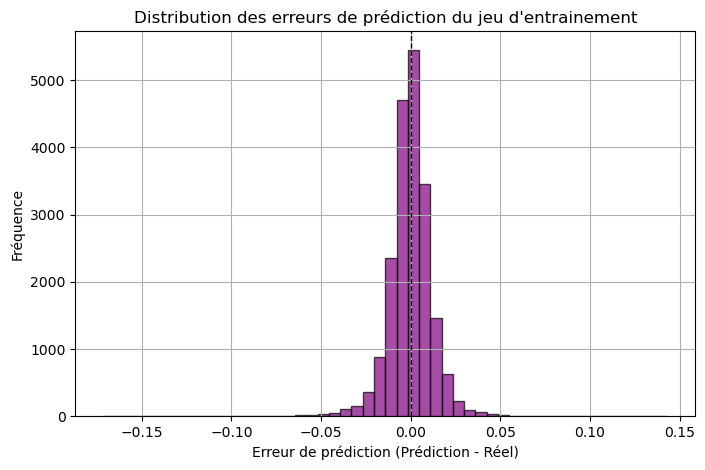

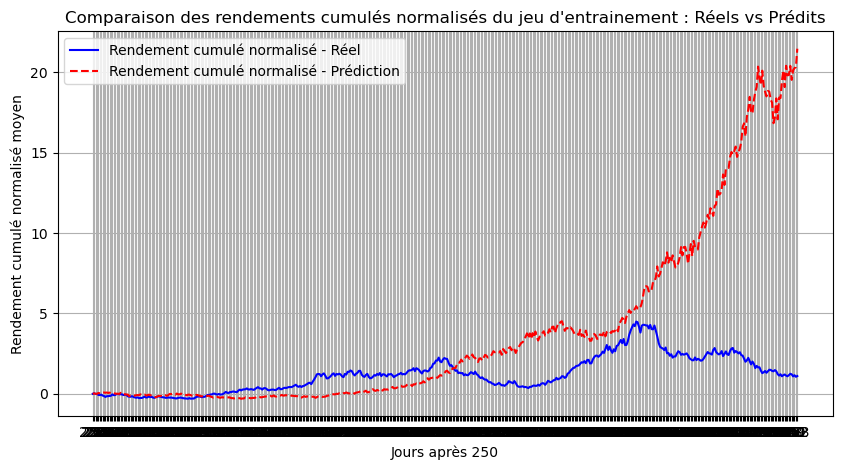

📊 Performance du modèle sur jeu de test :
✅ Valeur de la metrique : 0.068500
✅ Erreur quadratique moyenne (MSE) : 0.000220
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.014836
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0868


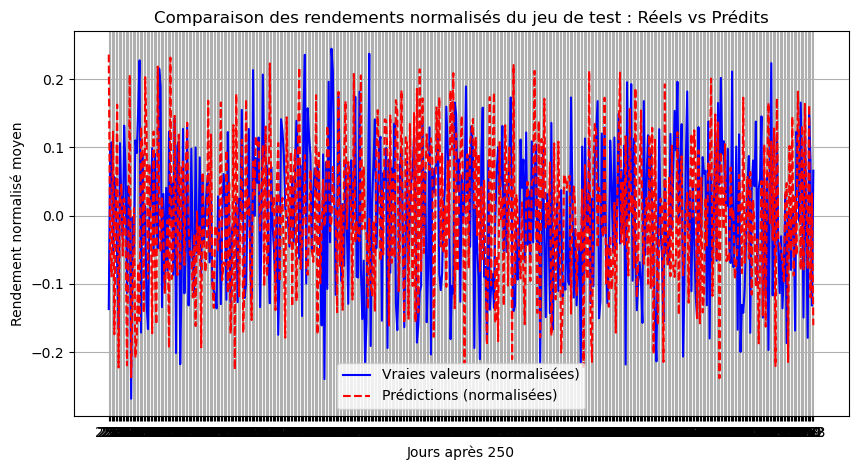

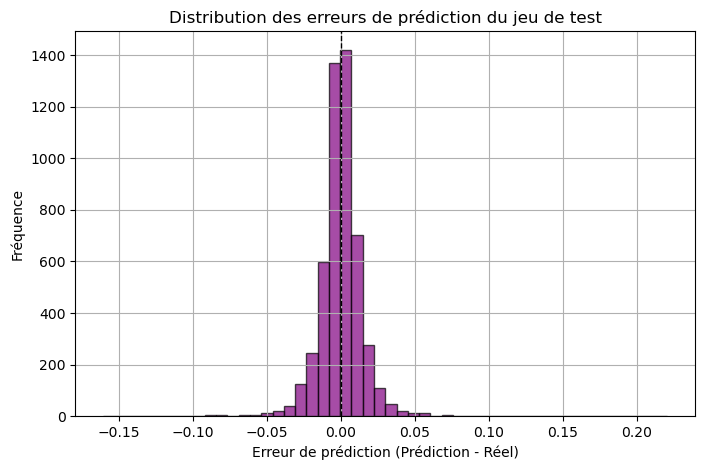

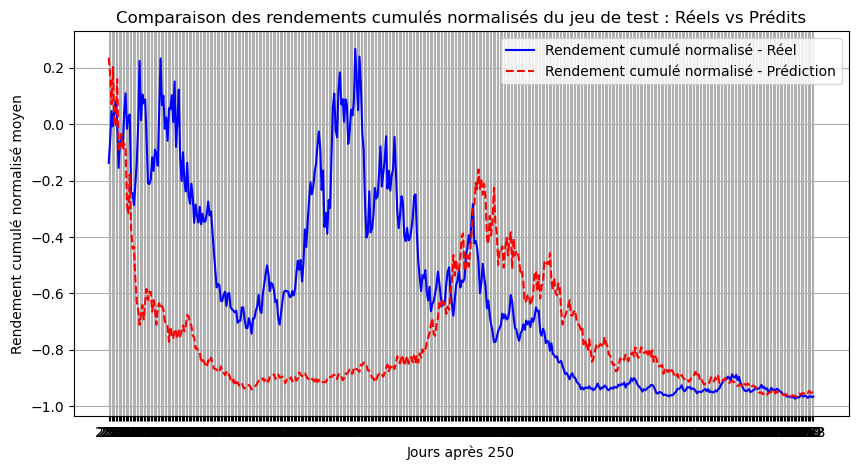

In [13]:
# Alternative ajustée de K means avec :
# ajout de retards pour prendre en compte la dynamique temporelle et regression quantile pour mieux capturer les extrêmes
# utilisation également de la méthode de GMM pour le clustering, plus flexible que K-means et permettant de modéliser des distributions plus complexes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.linear_model import QuantileRegressor

def add_temporal_features(X):
    X = pd.DataFrame(X)

    # Appliquer sur l'axe des lignes (jours)
    X_lag = X.shift(1, axis=0)
    X_diff = X.diff(1, axis=0)
    
    X = pd.concat([X, X_lag, X_diff], axis=1)  # Ajoute les nouvelles features
    X.fillna(0, inplace=True)  # Remplace les NaN initiaux

    return X.to_numpy()


# 📌 2️⃣ Trouver le K optimal pour K-Means ou GMM
def find_optimal_k_elbow(X, max_k=50):
    inertias = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Inertie (SSE)')
    plt.title('Méthode du coude pour déterminer K')
    plt.grid(True)
    plt.show()

    k_optimal = int(input("Entrez la valeur optimale de K en fonction du graphique : "))
    return k_optimal

# 📌 3️⃣ Appliquer K-Means ou GMM
def apply_clustering(X, k, method="gmm"):
    if method == "kmeans":
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X)
    else:  # Default: GMM
        model = GaussianMixture(n_components=k, random_state=42)
        labels = model.fit_predict(X)
    
    return labels, model

# 📌 4️⃣ Visualiser les centroïdes des clusters
def plot_cluster_centroids(model, method="gmm"):
    if method == "kmeans":
        centroids = model.cluster_centers_
    else:  # Pour GMM, utiliser les moyennes des composantes gaussiennes
        centroids = model.means_
    
    plt.figure(figsize=(10, 5))
    for i in range(centroids.shape[0]):
        plt.plot(centroids[i], label=f'Cluster {i}')
    plt.legend()
    plt.title(f"Visualisation des centroïdes ({method.upper()})")
    plt.show()

# 📌 5️⃣ Générer la matrice A à partir des distances aux clusters
def generate_factors_from_clusters(X_pca, best_cluster_model, method="gmm"):
    if method == "kmeans":
        centroids = best_cluster_model.cluster_centers_
    else:
        centroids = best_cluster_model.means_

    X_pca = np.array(X_pca)
    
    if X_pca.shape[1] != centroids.shape[1]:
        raise ValueError(f"Incompatibilité des dimensions : X_pca={X_pca.shape}, centroids={centroids.shape}")

    distances = np.linalg.norm(X_pca[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    
    A = distances[:250, :]
    A, _ = np.linalg.qr(A)

    return A

# 📌 6️⃣ Régression Quantile pour mieux capturer les extrêmes
def compute_quantile_regression(X_train, Y_train, features, quantile=0.5):
    
    print("X_train shape:", X_train.shape)
    print("features shape:", features.shape)
    
    predictors = X_train @ features
    targets = Y_train.T.stack()

    model = QuantileRegressor(quantile=quantile, alpha=0)  # alpha=0 = pas de régularisation
    model.fit(predictors, targets)
    
    return model.coef_

# 📌 7️⃣ Lancement du modèle complet avec choix entre K-Means et GMM
def launch_clustering_model(X_train, best_k=None, method="gmm"):
    # 🔹 Réduction de dimension avec PCA
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_train.T)
    X_pca, _ = np.linalg.qr(X_pca)

    # 🔹 Ajout de features temporelles
    X_pca = add_temporal_features(X_pca)

    # 🔹 Trouver K optimal
    if best_k is None:
        best_k = find_optimal_k_elbow(X_pca)

    # 🔹 Appliquer Clustering
    labels, best_cluster_model = apply_clustering(X_pca, best_k, method=method)

    # 🔹 Visualisation des clusters
    plot_cluster_centroids(best_cluster_model, method)

    # 🔹 Générer la matrice A
    A = generate_factors_from_clusters(X_pca, best_cluster_model, method)

    return A, best_k


# Lancer le modèle avec GMM
A, best_k = launch_clustering_model(X_train, method="gmm")

# Evaluation du modèle sur le jeu de train
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape) 

# Evaluation du modèle sur le jeu de test
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,istrain=False)

## Partie V - Modèles Supervisés

- Le clustering (K-Means) suppose implicitement que les rendements suivent une certaine structure géométrique (ex. groupes homogènes).
En réalité, les dynamiques de marché sont souvent non linéaires et dépendantes du temps.
- Un modèle de Boosting (comme XGBoost) apprend directement la relation entre les facteurs et les rendements en capturant des interactions non linéaires complexes.

## Modèle Supervisé I : Boosting

XGBoost (Extreme Gradient Boosting) est un algorithme d’apprentissage supervisé basé sur un ensemble d’arbres de décision entraînés séquentiellement. Contrairement à un arbre de décision classique qui effectue une seule prédiction, XGBoost ajoute progressivement plusieurs arbres, où chaque nouvel arbre est entraîné pour corriger les erreurs des arbres précédents.

Dans notre cas, XGBoost est utilisé pour modéliser la relation entre les rendements passés et les facteurs latents de marché. Le modèle commence par un premier arbre qui fait une prédiction initiale des rendements futurs. Ensuite, un second arbre est entraîné pour prédire les erreurs (résidus) du premier, et ainsi de suite. À la fin du processus, la prédiction finale est obtenue en combinant les prédictions de tous les arbres. Cette approche pourrait être intéressante pour mieux capturer la sous-estimation des tendances (et donc ajuster le biais des précédents modèles) des rendements cumulés notamment en ajustant progressivement les erreurs de prédictions précédentes.

Afin d’assurer la robustesse et la généralisation du modèle, nous mettons  en place une validation croisée manuelle (K-Fold Cross Validation). Cette technique consiste à diviser le jeu de données en K sous-ensembles, et à entraîner XGBoost K fois, en utilisant chaque fois K-1 sous-ensembles pour l’entraînement et le dernier pour la validation. Cette approche permet de moyenner les performances du modèle sur plusieurs découpages de données, évitant ainsi qu’il ne s’adapte trop fortement à un seul jeu de données spécifique (overfitting).

De plus, nous avons mis en place une optimisation des hyperparamètres afin de sélectionner les meilleures configurations du modèle. Nous utilisons ParameterGrid, qui teste différentes combinaisons de paramètres tels que :

- Le nombre d’arbres (n_estimators) : Ajuste la complexité du modèle.
- Le taux d’apprentissage (learning_rate) : Contrôle la vitesse d’adaptation du modèle.
- La profondeur des arbres (max_depth) : Détermine le niveau de détail que chaque arbre peut capturer.
- Le sous-échantillonnage (subsample) : Réduit le risque d’overfitting en utilisant une fraction des données à chaque itération.
- Le nombre de caractéristiques utilisées (colsample_bytree) : Sélectionne un sous-ensemble de variables à chaque split d’un arbre.
Chaque combinaison d’hyperparamètres est évaluée à l’aide de la validation croisée, et le modèle ayant le meilleur score moyen est retenu. Pour éviter d’entraîner des modèles inutiles, j’ai aussi utilisé early_stopping_rounds, qui stoppe l’entraînement si le modèle ne s’améliore plus après un certain nombre d’itérations.

Enfin, après l’optimisation, on extrais les facteurs de marché en utilisant les valeurs des feuilles des arbres XGBoost, qu'on réduis avec PCA pour ne garder que les 10 facteurs les plus pertinents. Ces facteurs sont ensuite utilisés dans une régression linéaire pour prédire les rendements futurs.



In [14]:

# Permet d’afficher des messages de suivi à chaque étape du programme.
def log(message):
    print(f"🔄 {message}...")

# Préparation des données
def prepare_data(X_train, Y_train):
    log("Préparation des données")
    X_train_set = X_train.iloc[:, :250].T 
    Y_train_set = Y_train.T
    return X_train_set, Y_train_set


# Optimisation de XGBoost avec validation croisée manuelle
def optimize_xgboost(X_train,Y_train, n_splits=3):
    log("Optimisation du modèle avec validation croisée")

    # Définition des hyperparamètres à tester
    param_grid = {
         'n_estimators': [50,100,200],  
         'learning_rate': [0.01, 0.1, 0.2],  
         'max_depth': [3, 5, 7],  
         'subsample': [0.8, 1],  
         'colsample_bytree': [0.8, 1]  
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    # Création de la validation croisée (K-Fold)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Boucle sur toutes les combinaisons d’hyperparamètres
    for params in tqdm(ParameterGrid(param_grid), desc="🔍 Test d'hyperparamètres"):
        print(f"▶️ Test : {params}")  # Affichage des hyperparamètres en direct

        scores = []

        # Validation croisée 
        for train_index, valid_index in kf.split(X_train):
            #X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
            X_train_split = X_train.iloc[train_index]
            X_valid_split = X_train.iloc[valid_index]
            Y_train_split = Y_train.iloc[train_index]
            Y_valid_split = Y_train.iloc[valid_index]

            # Création du modèle avec les hyperparamètres actuels
            model = xgb.XGBRegressor(
                objective="reg:squarederror", 
                random_state=42, 
                verbosity=1,  
                early_stopping_rounds=10,  # Arrêt anticipé si pas d'amélioration
                **params
            )
            
            # Entraînement avec le jeu de validation pour early stopping
            model.fit(X_train_split, Y_train_split, eval_set=[(X_valid_split, Y_valid_split)], verbose=False)

            # Évaluation sur le jeu de validation
            score = model.score(X_valid_split, X_valid_split)
            scores.append(score)

        # Moyenne des scores de validation
        mean_score = np.mean(scores)

        # Mise à jour du meilleur modèle
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"✅ Meilleurs paramètres trouvés : {best_params}")
    return best_model

# Extraction des facteurs après optimisation
def extract_factors_from_xgboost(model, X_train,n_factors=10):
    log("Extraction des facteurs à partir de XGBoost")

    A_xgb = model.apply(X_train) # Extrait les valeurs des feuilles de chaque arbre comme nouveaux facteurs.

    # Réduction avec PCA pour ne pas avoir trop de facteurs
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_xgb)  # (250, n_factors)

    A_reduced, _ = np.linalg.qr(A_reduced) # Orthonormalise les facteurs.
    return A_reduced


def launch_xgboost_model(X_train,Y_train):
    log("Début du processus")

    X_train_set,Y_train_set = prepare_data(X_train,Y_train)
    xgb_best_model = optimize_xgboost(X_train_set,Y_train_set)
    A = extract_factors_from_xgboost(xgb_best_model, X_train_set, n_factors=10)

    print(A.shape)

    log("🎉 Processus terminé !")

    return A,xgb_best_model




🔄 Début du processus...
🔄 Préparation des données...
🔄 Optimisation du modèle avec validation croisée...


🔍 Test d'hyperparamètres:   0%|          | 0/108 [00:00<?, ?it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   1%|          | 1/108 [00:00<00:49,  2.17it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:   2%|▏         | 2/108 [00:00<00:41,  2.55it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   3%|▎         | 3/108 [00:01<00:41,  2.52it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:   4%|▎         | 4/108 [00:01<00:38,  2.67it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   5%|▍         | 5/108 [00:01<00:40,  2.57it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:   6%|▌         | 6/108 [00:02<00:39,  2.61it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   6%|▋         | 7/108 [00:03<01:05,  1.54it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:   7%|▋         | 8/108 [00:04<01:10,  1.41it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   8%|▊         | 9/108 [00:05<01:19,  1.24it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:   9%|▉         | 10/108 [00:06<01:20,  1.21it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  10%|█         | 11/108 [00:07<01:25,  1.14it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  11%|█         | 12/108 [00:08<01:22,  1.17it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  12%|█▏        | 13/108 [00:09<01:47,  1.13s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  13%|█▎        | 14/108 [00:11<02:08,  1.36s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  14%|█▍        | 15/108 [00:13<02:14,  1.45s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  15%|█▍        | 16/108 [00:15<02:27,  1.60s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  16%|█▌        | 17/108 [00:17<02:30,  1.66s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  17%|█▋        | 18/108 [00:18<02:30,  1.67s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  18%|█▊        | 19/108 [00:19<01:53,  1.28s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  19%|█▊        | 20/108 [00:19<01:28,  1.00s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  19%|█▉        | 21/108 [00:19<01:11,  1.22it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  20%|██        | 22/108 [00:20<00:57,  1.48it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  21%|██▏       | 23/108 [00:20<00:50,  1.70it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  22%|██▏       | 24/108 [00:21<00:43,  1.91it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  23%|██▎       | 25/108 [00:21<00:52,  1.58it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  24%|██▍       | 26/108 [00:22<00:58,  1.40it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  25%|██▌       | 27/108 [00:23<01:02,  1.31it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  26%|██▌       | 28/108 [00:24<01:03,  1.26it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  27%|██▋       | 29/108 [00:25<01:03,  1.25it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  28%|██▊       | 30/108 [00:26<01:02,  1.24it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  29%|██▊       | 31/108 [00:27<01:21,  1.06s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  30%|██▉       | 32/108 [00:29<01:28,  1.16s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  31%|███       | 33/108 [00:30<01:32,  1.24s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  31%|███▏      | 34/108 [00:32<01:38,  1.33s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  32%|███▏      | 35/108 [00:33<01:43,  1.42s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  33%|███▎      | 36/108 [00:35<01:49,  1.52s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  34%|███▍      | 37/108 [00:35<01:23,  1.17s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  35%|███▌      | 38/108 [00:36<01:05,  1.07it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  36%|███▌      | 39/108 [00:36<00:52,  1.31it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  37%|███▋      | 40/108 [00:37<00:43,  1.55it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  38%|███▊      | 41/108 [00:37<00:37,  1.78it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  39%|███▉      | 42/108 [00:37<00:32,  2.00it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  40%|███▉      | 43/108 [00:38<00:38,  1.70it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  41%|████      | 44/108 [00:39<00:42,  1.50it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  42%|████▏     | 45/108 [00:40<00:44,  1.41it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  43%|████▎     | 46/108 [00:41<00:45,  1.35it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  44%|████▎     | 47/108 [00:41<00:46,  1.31it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  44%|████▍     | 48/108 [00:42<00:47,  1.26it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  45%|████▌     | 49/108 [00:44<00:58,  1.01it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  46%|████▋     | 50/108 [00:45<01:09,  1.19s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  47%|████▋     | 51/108 [00:47<01:12,  1.28s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  48%|████▊     | 52/108 [00:49<01:18,  1.40s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  49%|████▉     | 53/108 [00:50<01:20,  1.46s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  50%|█████     | 54/108 [00:52<01:25,  1.58s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  51%|█████     | 55/108 [00:53<01:07,  1.28s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  52%|█████▏    | 56/108 [00:53<00:54,  1.04s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  53%|█████▎    | 57/108 [00:54<00:48,  1.05it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  54%|█████▎    | 58/108 [00:54<00:40,  1.25it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  55%|█████▍    | 59/108 [00:55<00:35,  1.36it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  56%|█████▌    | 60/108 [00:55<00:30,  1.56it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  56%|█████▋    | 61/108 [00:56<00:37,  1.26it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  57%|█████▋    | 62/108 [00:57<00:40,  1.15it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  58%|█████▊    | 63/108 [00:59<00:43,  1.05it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  59%|█████▉    | 64/108 [01:00<00:43,  1.02it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  60%|██████    | 65/108 [01:01<00:44,  1.04s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  61%|██████    | 66/108 [01:02<00:42,  1.01s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  62%|██████▏   | 67/108 [01:04<00:50,  1.24s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  63%|██████▎   | 68/108 [01:05<00:56,  1.41s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  64%|██████▍   | 69/108 [01:07<01:01,  1.58s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  65%|██████▍   | 70/108 [01:09<01:05,  1.73s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  66%|██████▌   | 71/108 [01:11<01:06,  1.80s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  67%|██████▋   | 72/108 [01:13<01:05,  1.83s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  68%|██████▊   | 73/108 [01:14<00:48,  1.40s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  69%|██████▊   | 74/108 [01:14<00:37,  1.09s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  69%|██████▉   | 75/108 [01:14<00:28,  1.14it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  70%|███████   | 76/108 [01:15<00:23,  1.38it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  71%|███████▏  | 77/108 [01:15<00:19,  1.62it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  72%|███████▏  | 78/108 [01:16<00:16,  1.81it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  73%|███████▎  | 79/108 [01:16<00:19,  1.51it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  74%|███████▍  | 80/108 [01:17<00:20,  1.34it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  75%|███████▌  | 81/108 [01:18<00:20,  1.29it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  76%|███████▌  | 82/108 [01:19<00:21,  1.21it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  77%|███████▋  | 83/108 [01:20<00:20,  1.19it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  78%|███████▊  | 84/108 [01:21<00:20,  1.18it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  79%|███████▊  | 85/108 [01:22<00:24,  1.06s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  80%|███████▉  | 86/108 [01:24<00:27,  1.27s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  81%|████████  | 87/108 [01:26<00:28,  1.37s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  81%|████████▏ | 88/108 [01:28<00:29,  1.49s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  82%|████████▏ | 89/108 [01:29<00:29,  1.54s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  83%|████████▎ | 90/108 [01:31<00:29,  1.62s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  84%|████████▍ | 91/108 [01:31<00:21,  1.26s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  85%|████████▌ | 92/108 [01:32<00:15,  1.00it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  86%|████████▌ | 93/108 [01:32<00:12,  1.23it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  87%|████████▋ | 94/108 [01:33<00:09,  1.46it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  88%|████████▊ | 95/108 [01:33<00:08,  1.57it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  89%|████████▉ | 96/108 [01:34<00:06,  1.79it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  90%|████████▉ | 97/108 [01:34<00:07,  1.55it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  91%|█████████ | 98/108 [01:35<00:07,  1.40it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  92%|█████████▏| 99/108 [01:36<00:06,  1.29it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  93%|█████████▎| 100/108 [01:37<00:06,  1.19it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  94%|█████████▎| 101/108 [01:38<00:06,  1.12it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  94%|█████████▍| 102/108 [01:39<00:05,  1.07it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  95%|█████████▌| 103/108 [01:41<00:05,  1.18s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  96%|█████████▋| 104/108 [01:43<00:05,  1.43s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  97%|█████████▋| 105/108 [01:45<00:04,  1.55s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  98%|█████████▊| 106/108 [01:47<00:03,  1.68s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  99%|█████████▉| 107/108 [01:49<00:01,  1.76s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres: 100%|██████████| 108/108 [01:51<00:00,  1.03s/it]


✅ Meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}
🔄 Extraction des facteurs à partir de XGBoost...
(250, 10)
🔄 🎉 Processus terminé !...
📊 Performance du modèle sur jeu d'entrainement :
✅ Valeur de la metrique : 0.041767
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.012130
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0451


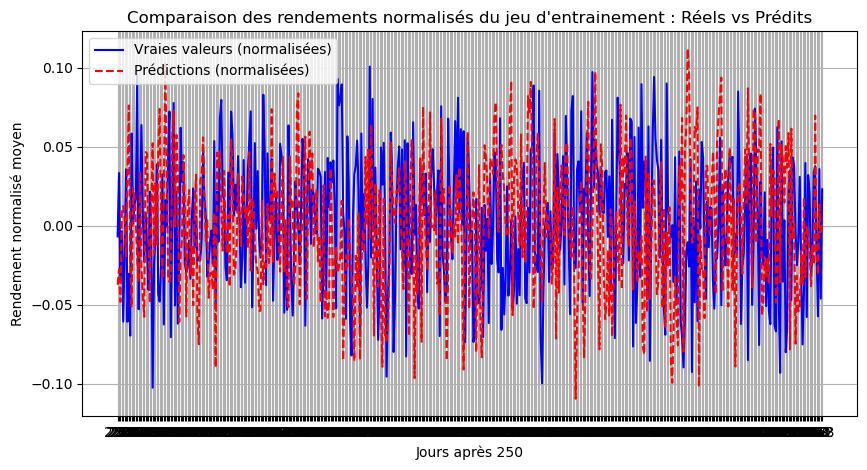

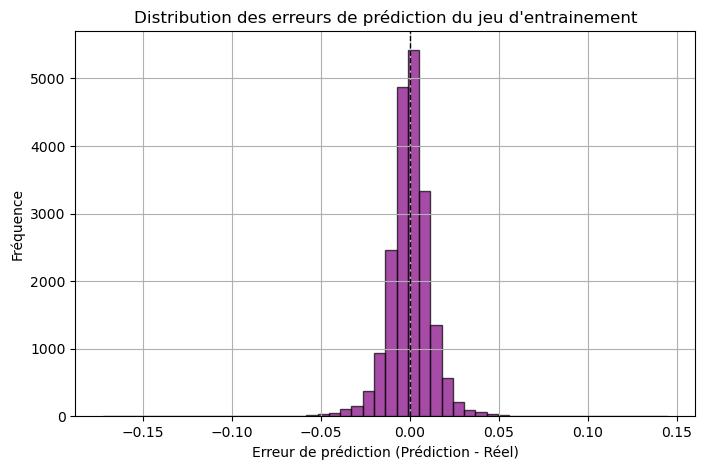

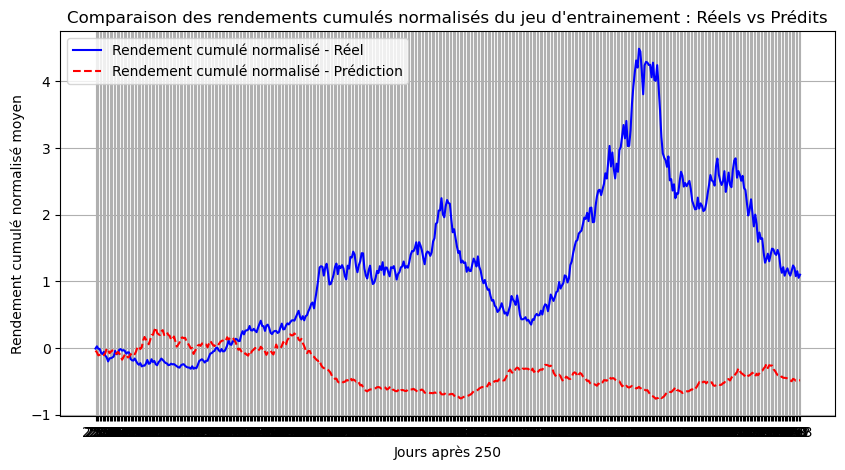

📊 Performance du modèle sur jeu de test :
✅ Valeur de la metrique : 0.045775
✅ Erreur quadratique moyenne (MSE) : 0.000221
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.014869
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0561


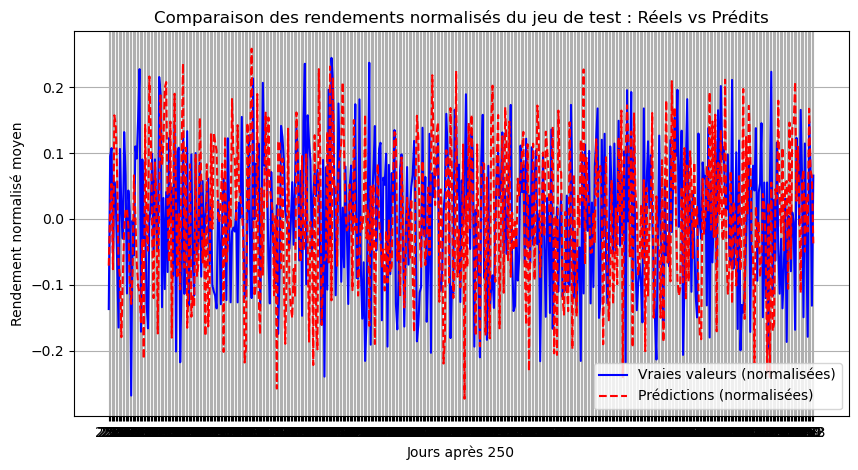

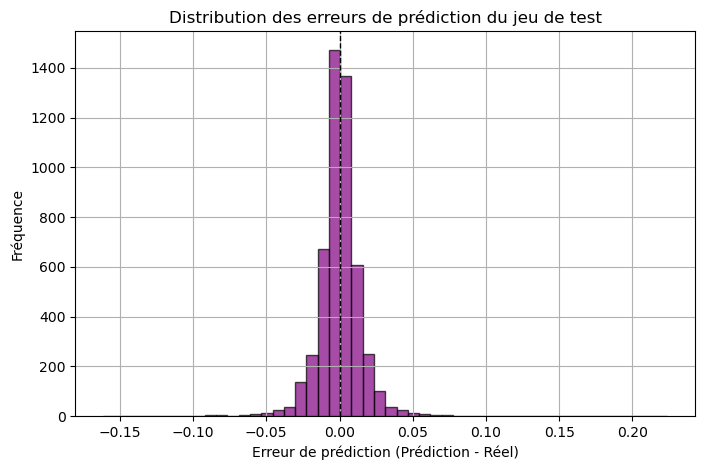

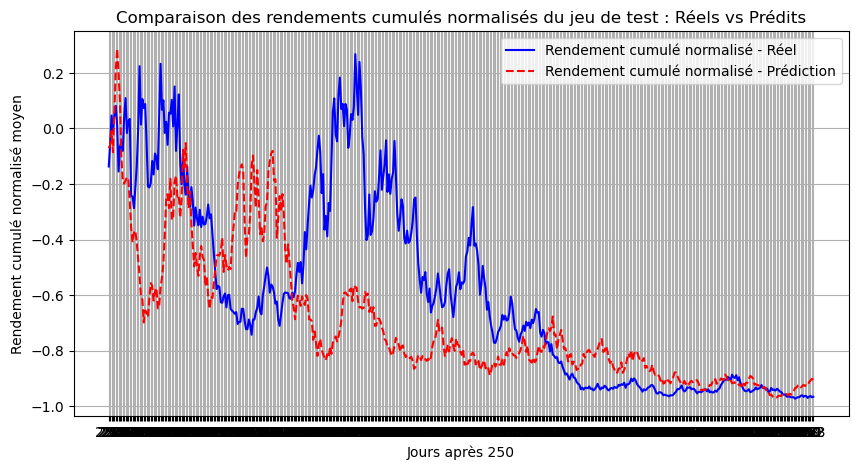

In [15]:
#Lancement du modèle XGBoost
A,xgb_best_model= launch_xgboost_model(X_train,Y_train)

# Evaluation du modèle sur le jeu de train
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape)

# Evaluation du modèle sur le jeu de test
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,istrain=False) 

Résultats bien moins bon (metric a 0,045 sur le set de test) que le modèle de clustering, contrairement à ce qui était attendu dans l'ajustement de tendance, la prédiction des rendements cumulés progresse à contre tendance et reste un peu plus convenable lorsqu'il n'y a pas vraiment de tendance particulière. 

## Modèle Supervisé II : Bagging
Le Bagging (Bootstrap Aggregating) est une méthode d’ensemble qui entraîne plusieurs modèles indépendants sur des échantillons bootstrap des données. Contrairement au Boosting, qui corrige itérativement les erreurs des modèles précédents, le Bagging entraîne ses modèles en parallèle et moyenne leurs prédictions pour réduire la variance.

Dans notre cas, Bagging est utilisé pour modéliser la relation entre les rendements passés et les facteurs latents de marché. Chaque modèle du Bagging est un arbre de décision, entraîné sur des sous-échantillons des données. L’objectif est d’obtenir un modèle robuste, réduisant la variance tout en capturant des structures complexes dans les données. La ou le boosting ne permettait pas de réussir à ajuster les erreur de prediction de tendance (plutôt des correctifs locaux), le bagging pourrait éventuellement mieux généraliser les tendances à l'aide de différents échantillons entrainés indépendamment et donc mieux représenter des sous-régimes.

Afin d’assurer la robustesse et la généralisation du modèle, nous utilisons une validation croisée (K-Fold Cross Validation). Cette technique permet d’évaluer la stabilité du modèle en testant plusieurs découpages des données.
Nous optimisons également les hyperparamètres via une recherche sur grille (ParameterGrid), en testant différentes valeurs de :

- n_estimators : Nombre d’arbres dans le modèle Bagging.
- max_samples : Proportion de l’échantillon utilisée par chaque arbre.
- max_features : Nombre de variables utilisées pour chaque modèle.

Enfin, après l’optimisation, nous extrayons les facteurs de marché en utilisant les prédictions des modèles entraînés, puis nous appliquons une réduction dimensionnelle via PCA pour conserver uniquement les 10 facteurs les plus pertinents.


In [21]:
# Optimisation du modèle Bagging avec validation croisée (K-Fold)
def optimize_bagging(X_train, Y_train, n_splits=3):
    log("Optimisation du modèle avec validation croisée K-Fold")

    param_grid = {
        'n_estimators': [50, 100, 200],  # Nombre d'arbres
        'max_samples': [0.5, 0.7, 1.0],  # Échantillonnage bootstrap
        'max_features': [0.5, 0.7, 1.0]  # Sélection aléatoire de features
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Test de toutes les combinaisons d’hyperparamètres
    for params in tqdm(ParameterGrid(param_grid), desc="🔍 Test d'hyperparamètres"):
        print(f"▶️ Test : {params}")

        scores = []

        # Validation croisée (K-Fold)
        for train_index, valid_index in kf.split(X_train):
            X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
            Y_train_split, Y_valid_split = Y_train.iloc[train_index], Y_train.iloc[valid_index]

            # Création du modèle avec les hyperparamètres actuels
            model = BaggingRegressor(
                estimator=DecisionTreeRegressor(),
                random_state=42,
                n_jobs=-1 # Utilisation de tous les coeurs
                **params
            )

            # Entraînement sur l’ensemble d’apprentissage
            model.fit(X_train_split, Y_train_split)

            # Prédiction et évaluation
            score = mean_squared_error(Y_valid_split, model.predict(X_valid_split))
            scores.append(score)

        mean_score = np.mean(scores)

        # Mise à jour du meilleur modèle
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"✅ Meilleurs paramètres trouvés : {best_params}")
    return best_model

# Extraction des facteurs via Bagging et réduction avec PCA
def extract_factors_from_bagging(model, X_train, n_factors=10):
    log("Extraction des facteurs à partir de Bagging")

    A_bagging = model.predict(X_train)  # On prend les prédictions comme nouveaux facteurs

    # Réduction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_bagging)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced

def launch_bagging_model(X_train,Y_train):
    log("Début du processus")

    X_train_set, Y_train_set = prepare_data(X_train, Y_train)

    bagging_best_model = optimize_bagging(X_train_set, Y_train_set)

    A = extract_factors_from_bagging(bagging_best_model, X_train_set, n_factors=10)

    print(A.shape)

    log("🎉 Processus terminé !")

    return A,bagging_best_model




🔄 Début du processus...
🔄 Préparation des données...
🔄 Optimisation du modèle avec validation croisée K-Fold...


🔍 Test d'hyperparamètres:   0%|          | 0/27 [00:00<?, ?it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}


🔍 Test d'hyperparamètres:   4%|▎         | 1/27 [00:00<00:06,  4.04it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}


🔍 Test d'hyperparamètres:   7%|▋         | 2/27 [00:00<00:09,  2.72it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  11%|█         | 3/27 [00:01<00:14,  1.68it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  15%|█▍        | 4/27 [00:01<00:10,  2.12it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  19%|█▊        | 5/27 [00:02<00:11,  1.97it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  22%|██▏       | 6/27 [00:03<00:14,  1.40it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  26%|██▌       | 7/27 [00:03<00:11,  1.68it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  30%|██▉       | 8/27 [00:04<00:12,  1.56it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  33%|███▎      | 9/27 [00:06<00:16,  1.09it/s]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  37%|███▋      | 10/27 [00:06<00:12,  1.38it/s]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  41%|████      | 11/27 [00:06<00:10,  1.49it/s]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  44%|████▍     | 12/27 [00:08<00:12,  1.21it/s]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  48%|████▊     | 13/27 [00:08<00:09,  1.44it/s]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  52%|█████▏    | 14/27 [00:09<00:09,  1.43it/s]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  56%|█████▌    | 15/27 [00:10<00:11,  1.08it/s]

▶️ Test : {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  59%|█████▉    | 16/27 [00:11<00:08,  1.27it/s]

▶️ Test : {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  63%|██████▎   | 17/27 [00:12<00:08,  1.20it/s]

▶️ Test : {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  67%|██████▋   | 18/27 [00:14<00:10,  1.15s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  70%|███████   | 19/27 [00:14<00:07,  1.09it/s]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  74%|███████▍  | 20/27 [00:15<00:05,  1.17it/s]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  78%|███████▊  | 21/27 [00:16<00:06,  1.04s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  81%|████████▏ | 22/27 [00:17<00:04,  1.14it/s]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  85%|████████▌ | 23/27 [00:18<00:03,  1.11it/s]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  89%|████████▉ | 24/27 [00:19<00:03,  1.22s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  93%|█████████▎| 25/27 [00:20<00:02,  1.05s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  96%|█████████▋| 26/27 [00:21<00:01,  1.13s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


🔍 Test d'hyperparamètres: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


✅ Meilleurs paramètres trouvés : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}
🔄 Extraction des facteurs à partir de Bagging...
(250, 10)
🔄 🎉 Processus terminé !...
📊 Performance du modèle sur jeu d'entrainement :
✅ Valeur de la metrique : 0.027574
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.012135
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0350


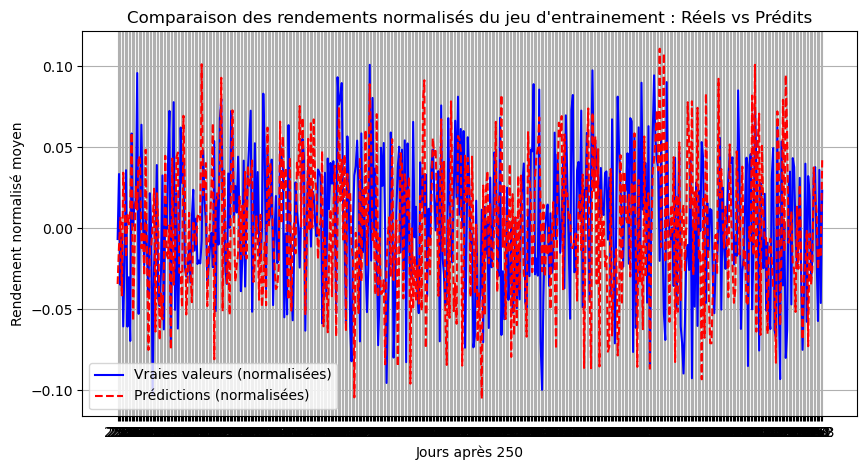

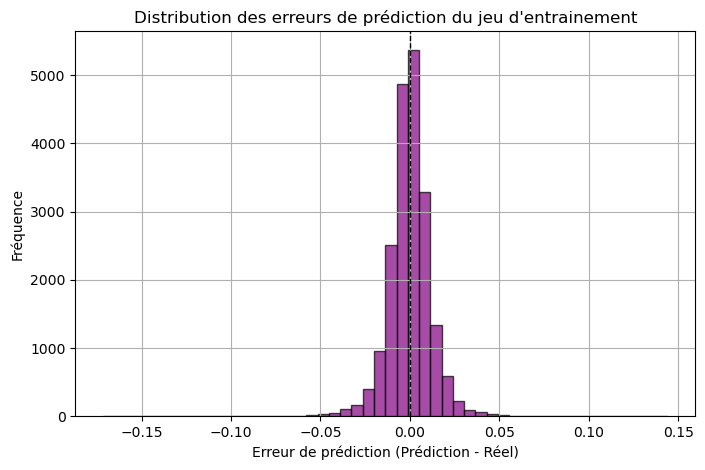

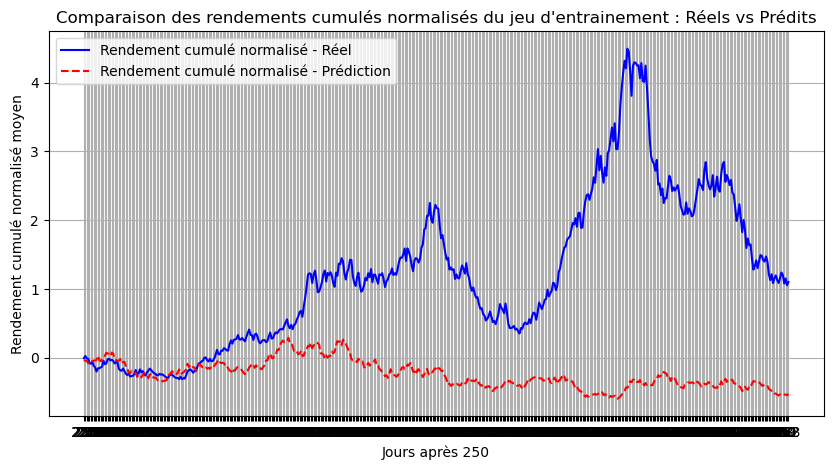

📊 Performance du modèle sur jeu de test :
✅ Valeur de la metrique : 0.039196
✅ Erreur quadratique moyenne (MSE) : 0.000221
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.014877
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0454


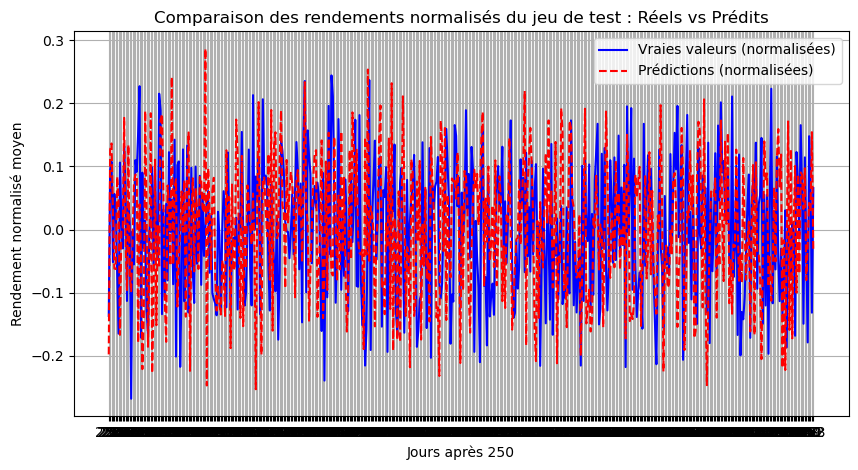

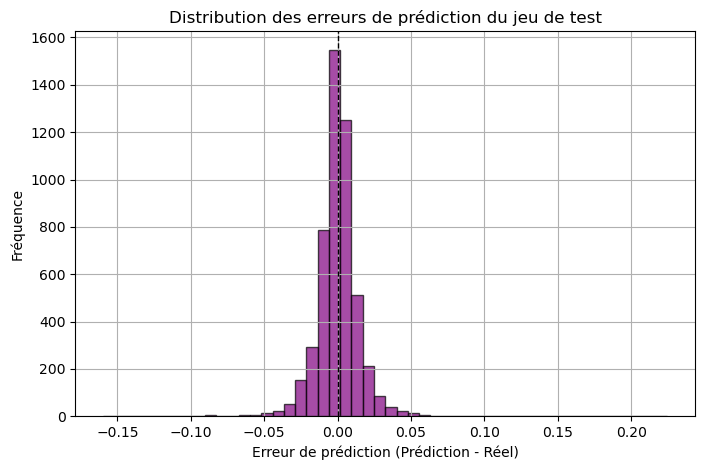

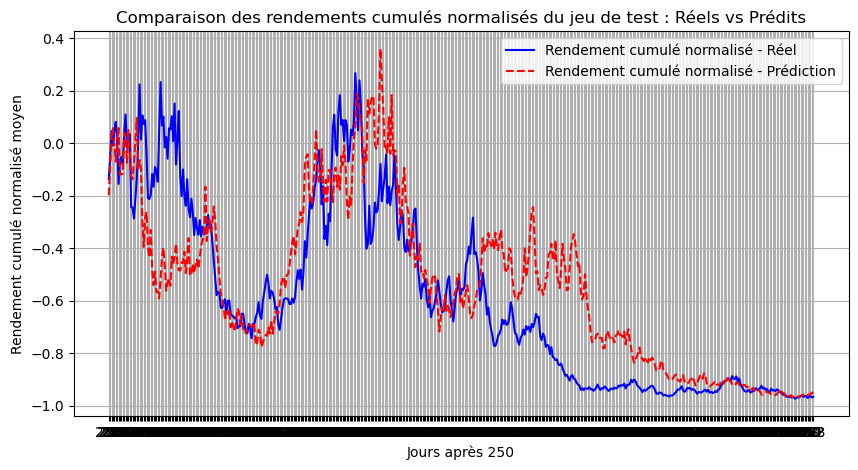

In [22]:
#Lancement du modèle Bagging
A,bagging_best_model = launch_bagging_model(X_train,Y_train)

# Evaluation du modèle sur le jeu de train
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape) 

# Evaluation du modèle sur le jeu de test
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,istrain=False) 


Nous observons que la performance du train set n'est toujours pas améliorée avec la méthode de bagging. La metric s'améliore avec le test set en suivant un peu mieux les tendances mais le modèle n'est toujours pas assez robuste pour capturer le bruit. 

## Modèle Supervisé III : Random Forest
Le Random Forest est une méthode d’ensemble basée sur l’agrégation de plusieurs arbres de décision. Contrairement à un simple arbre de décision, qui est sujet au sur-apprentissage, Random Forest construit plusieurs arbres indépendants et moyenne leurs prédictions pour réduire la variance et améliorer la robustesse du modèle.

Dans notre cas, Random Forest est utilisé pour modéliser la relation entre les rendements passés et les facteurs latents du marché. Chaque arbre est entraîné sur un sous-échantillon des données, et une sélection aléatoire des variables est effectuée à chaque division (split). Cela permet d’introduire encore plus de diversité dans les modèles et d’éviter un sur-ajustement à certaines variables spécifiques avec le côté randomisé des sous ensembles des variables.

Afin d’assurer la robustesse et la généralisation du modèle, nous utilisons l’Out-Of-Bag (OOB) Score, qui permet d’évaluer la performance sans avoir recours à une validation croisée classique. L’OOB Score est calculé en utilisant les observations qui ne sont pas sélectionnées dans l’échantillonnage bootstrap, offrant ainsi une estimation fiable de l’erreur du modèle.

Nous optimisons également les hyperparamètres via une recherche sur grille (Grid Search), en testant différentes valeurs de :

n_estimators : Nombre d’arbres dans la forêt.
max_features : Nombre de variables considérées pour chaque split, avec des valeurs comme sqrt, log2 ou une fraction du nombre total de variables.
Enfin, après l’optimisation, nous extrayons les facteurs de marché en utilisant les prédictions du modèle entraîné, puis nous appliquons une réduction dimensionnelle via PCA pour conserver uniquement les 10 facteurs les plus pertinents.

In [24]:
# Optimisation du modèle Random Forest en utilisant OOB Score
def optimize_random_forest_oob(X_train, Y_train):
    log("Optimisation du modèle Random Forest avec OOB Score")

    param_grid = {
        'n_estimators': [50, 100, 200],  # Nombre d'arbres
        'max_features': ['sqrt', 'log2', 0.5]  # Sélection aléatoire des features
    }

    best_model = None
    best_oob_score = float('-inf')
    best_params = None

    for params in tqdm(ParameterGrid(param_grid), desc="🔍 Test d'hyperparamètres"):
        log(f"▶️ Test : {params}")

        # Création du modèle avec les paramètres actuels
        model = RandomForestRegressor(
            oob_score=True,  # Activation du OOB Score
            random_state=42,
            n_jobs=-1,  # Utilisation de tous les cœurs pour accélérer l'entraînement
            **params
        )

        model.fit(X_train, Y_train)  # OOB est calculé automatiquement

        # Vérification du OOB Score
        if hasattr(model, "oob_score_"):  # Parfois oob_score_ peut ne pas exister
            oob_score = model.oob_score_
        else:
            oob_score = float('-inf')

        if oob_score > best_oob_score:  # Maximisation du OOB Score
            best_oob_score = oob_score
            best_model = model
            best_params = params

    log("✅ Meilleurs paramètres trouvés : {best_params} avec OOB Score = {best_oob_score:.4f}")
    return best_model

# Extraction des facteurs via Random Forest et réduction avec PCA
def extract_factors_from_rf(model, X_train, n_factors=10):
    log("Extraction des facteurs à partir de Random Forest")

    A_rf = model.predict(X_train)  # Prédictions utilisées comme facteurs

    # Réduction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_rf)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced


def launch_random_forest_model(X_train,Y_train):
    log("Début du processus")

    X_train_set, Y_train_set = prepare_data(X_train, Y_train)

    rf_best_model = optimize_random_forest_oob(X_train_set, Y_train_set)
    A = extract_factors_from_rf(rf_best_model, X_train_set, n_factors=10)

    print(A.shape)


    log("🎉 Processus terminé !")

    return A,rf_best_model


Début du processus...
Préparation des données...
Optimisation du modèle Random Forest avec OOB Score...


🔍 Test d'hyperparamètres:  11%|█         | 1/9 [00:00<00:00,  9.79it/s]

▶️ Test : {'max_features': 'sqrt', 'n_estimators': 50}...
▶️ Test : {'max_features': 'sqrt', 'n_estimators': 100}...
▶️ Test : {'max_features': 'sqrt', 'n_estimators': 200}...


🔍 Test d'hyperparamètres:  56%|█████▌    | 5/9 [00:00<00:00, 13.12it/s]

▶️ Test : {'max_features': 'log2', 'n_estimators': 50}...
▶️ Test : {'max_features': 'log2', 'n_estimators': 100}...
▶️ Test : {'max_features': 'log2', 'n_estimators': 200}...


🔍 Test d'hyperparamètres:  78%|███████▊  | 7/9 [00:00<00:00, 12.05it/s]

▶️ Test : {'max_features': 0.5, 'n_estimators': 50}...
▶️ Test : {'max_features': 0.5, 'n_estimators': 100}...
▶️ Test : {'max_features': 0.5, 'n_estimators': 200}...


🔍 Test d'hyperparamètres: 100%|██████████| 9/9 [00:00<00:00,  9.76it/s]


✅ Meilleurs paramètres trouvés : {best_params} avec OOB Score = {best_oob_score:.4f}...
Extraction des facteurs à partir de Random Forest...
(250, 10)
🎉 Processus terminé !...
📊 Performance du modèle sur jeu d'entrainement :
✅ Valeur de la metrique : 0.023407
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.012137
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0299


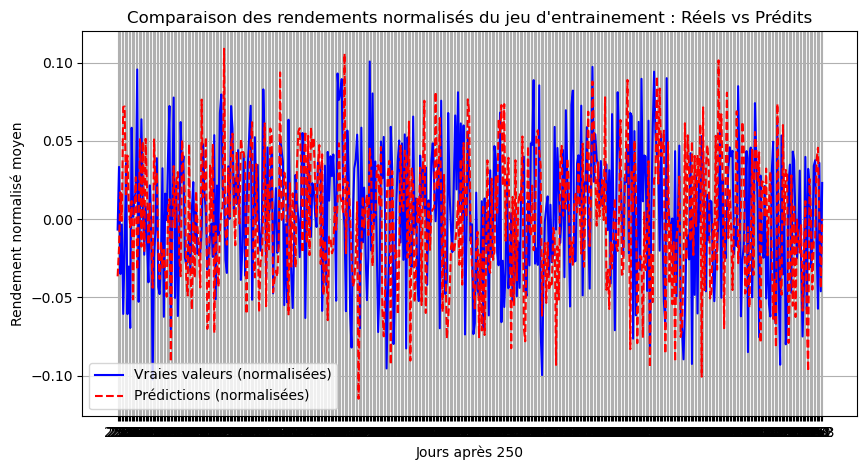

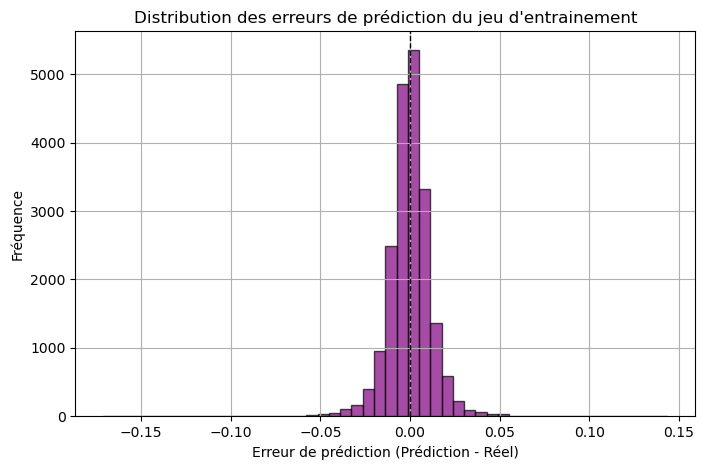

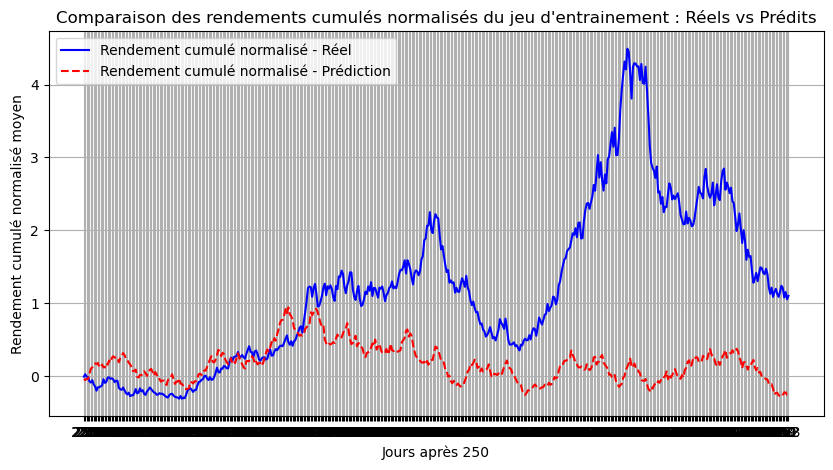

📊 Performance du modèle sur jeu de test :
✅ Valeur de la metrique : 0.044908
✅ Erreur quadratique moyenne (MSE) : 0.000221
✅ Racine de l'erreur quadratique moyenne (RMSE) : 0.014868
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0569


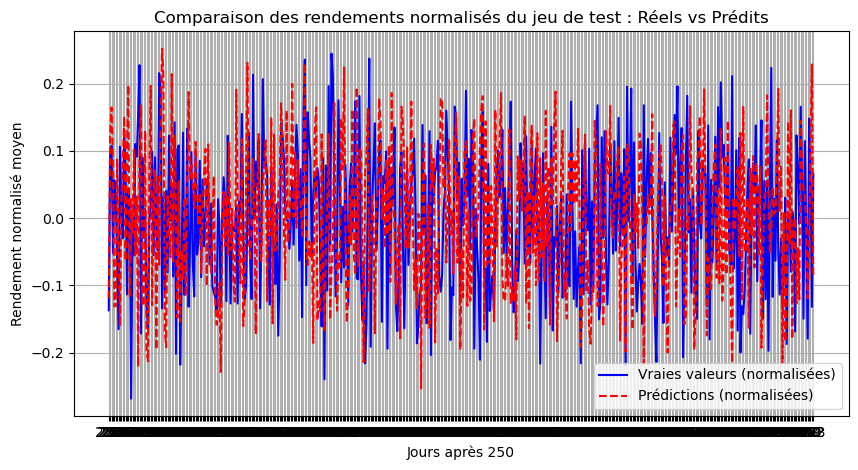

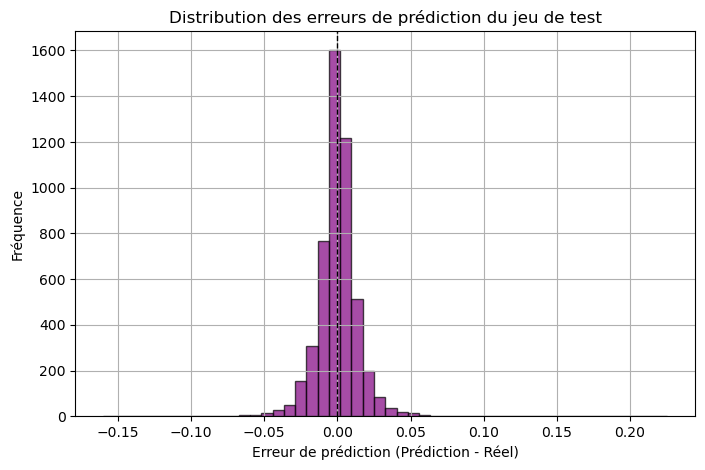

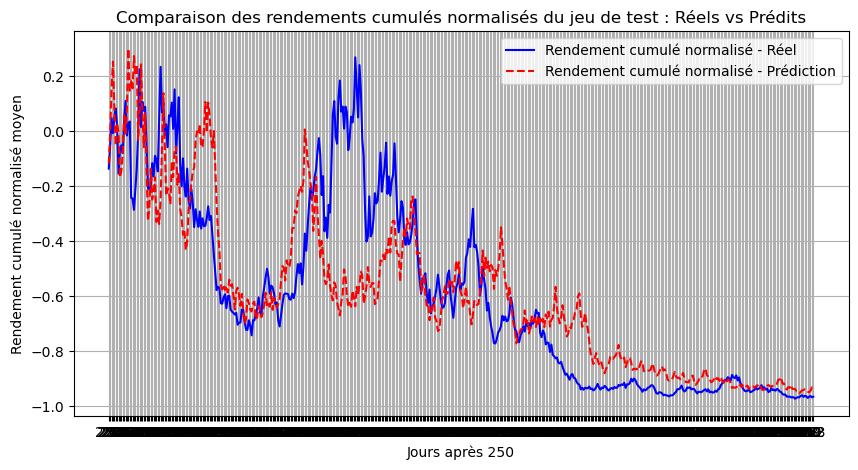

In [25]:
#Lancement du modèle Random Forest
A,rf_best_model = launch_random_forest_model(X_train,Y_train)

# Evaluation du modèle sur le jeu de train
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape) 

# Evaluation du modèle sur le jeu de test
#mse, correlation = predict_and_evaluate_avec_normalisation(A, beta, Y_test,X_test_reshape,istrain=False) 
mse, correlation = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,istrain=False) 



## Stratégie Financière :  

L'objectif de cette stratégie est de créer une fonction qui s'intègre aux modèles définis précédemment afin d'entraîner séquentiellement le modèle sur des données historiques et de réaliser des prévisions sur une plage de données plus courte. Cette approche permet d'ajuster en continu les paramètres du modèle aux conditions de marché récentes pour améliorer la qualité des prévisions. Le processus se décompose en trois étapes principales :

Entraînement pour obtenir la matrice A :
Le modèle est entraîné sur une fenêtre de 200 jours. À l'issue de cette phase, la fonction détermine la matrice A à partir des rendements passés, regroupant ainsi les vecteurs de coefficients caractéristiques du comportement historique des actifs.

Ajustement de β :
Sur une période d'ajustement de 50 jours suivant la fenêtre d'entraînement, les coefficients β sont déterminés par régression linéaire. Cette étape permet de calibrer le modèle en fonction des données récentes afin de capter les dynamiques de marché actuelles.

Prédiction :
La prévision s'effectue en deux sous-étapes :

Calcul des facteurs :
Les facteurs sont obtenus en multipliant la matrice A par les rendements des 50 jours utilisés pour l'ajustement de β.
Calcul des rendements prévus :
Les rendements futurs sont ensuite prédits en multipliant ces facteurs par le vecteur β.
Cette méthodologie permet de mettre à jour régulièrement les paramètres du modèle en fonction des données récentes, offrant ainsi une prévision dynamique et potentiellement plus précise des rendements futurs.

In [ ]:

def sliding_window_forecast(launch_model, X,Y_train, step=50, train_window=200, beta_fit_window=50,xgb_best_model=None,bagging_best_model=None,best_k=None,rf_best_model=None):
    n_days = X.shape[1]
    predictions = []
    actuals = []
    alphas_list = []
    betas_list = []
    
    # La fenêtre totale pour chaque itération correspond à la somme de la période d'entraînement et de celle pour ajuster β.
    total_window = train_window + beta_fit_window
    
    for start in range(0, n_days - total_window + 1, step):
        
        # Définition des indices :
        train_start    = start
        train_end      = start + train_window
        beta_fit_start = train_end
        beta_fit_end   = beta_fit_start + beta_fit_window
        
        # Obtention de alpha sur la période d'entraînement d'entrainement de 200 jours parmis les 250 jours utiliser pour la prédiction
        X_train_subset = X.iloc[:, train_start:train_end]
        Y_train_subset = X.iloc[:, beta_fit_start:beta_fit_end] #On veut apprendre au modèle a prédire les 50 prochains rendement (de 200 à 250)

        #alpha
        alpha = launch_model(X_train_subset,Y_train_subset)

        # Détermination de β sur la période beta_fit de 50 jours
        X_for_beta = X.iloc[:, train_start:beta_fit_end] # On utilise les rendements de X de train_start jusqu'à beta_fit_end.

        # Construction du design matrix par décalage pour respecter le format de donnée attendu par la fonction AQR
        X_train_reshape_input = pd.concat([ X_for_beta.T.shift(i+1).stack(future_stack=True) for i in range(train_window) ],axis=1).dropna()
        X_train_reshape_input.columns = pd.Index(range(1, train_window+1), name='timeLag')
        
        # Les cibles pour l'ajustement sont les rendements réels sur la période beta_fit (les 50 derniers jours de la fenêtre de train)
        #Y_train_subset = X.iloc[:, beta_fit_start:beta_fit_end]
        
        # Détermination de beta via la fonction fournie
        beta = fitBeta_with_input(alpha, X_train_reshape_input, Y_train_subset)

        # Prédiction des 50 prchains jours
        F_t = X_train_reshape_input @ alpha # Calcul des facteurs à partir du design matrix utilisé pour ajuster beta
        Y_pred = (F_t @ beta).unstack().T # Prédiction des rendements
        
        predictions.append(Y_pred)
        actuals.append(Y_train_subset)
        alphas_list.append(alpha)
        betas_list.append(beta)
    
    predictions_df = pd.concat(predictions, axis=1)
    actuals_df = pd.concat(actuals, axis=1)
    alphas_df = pd.concat([pd.DataFrame(a, index=range(1, a.shape[0]+1)) for a in alphas_list], axis=1)
    betas_df = pd.concat([pd.DataFrame(b, index=[f"factor_{i}" for i in range(1, b.shape[0]+1)]) for b in betas_list], axis=1)
    
    return predictions_df, actuals_df, alphas_df, betas_df




# Stratégie de Prédiction avec le modèle Clustering


In [28]:

# Prédiction avec le modèle Clustering
try:
    best_k
except NameError:
    _, best_k = launch_clustering_model(X_train)
    
predictions_df, actuals_df, alphas_df, betas_df = sliding_window_forecast(launch_clustering_model, X_train,best_k=best_k)


# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df.div(np.sqrt((actuals_df**2).sum()), axis=1)    
Ypred = predictions_df.div(np.sqrt((predictions_df**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df.values.flatten(), predictions_df.values.flatten())
correlation = np.corrcoef(actuals_df.values.flatten(), predictions_df.values.flatten())[0, 1]

# Affichage des performances
print(f"📊 Performance du modèle :")
print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")


# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("📈 Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("📊 Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("📈 Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()

ValueError: n_samples=133 should be >= n_clusters=499.


# Stratégie de Prédiction avec le modèle xgboost


In [17]:
# Prédiction avec le modèle XGBoost
predictions_df, actuals_df, alphas_df, betas_df = sliding_window_forecast(launch_xgboost_model, X_train,Y_train)

# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df.div(np.sqrt((actuals_df**2).sum()), axis=1)    
Ypred = predictions_df.div(np.sqrt((predictions_df**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df.values.flatten(), predictions_df.values.flatten())
correlation = np.corrcoef(actuals_df.values.flatten(), predictions_df.values.flatten())[0, 1]

# Affichage des performances
print(f"📊 Performance du modèle :")
print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")


# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("📈 Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("📊 Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("📈 Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


🔄 Début du processus...
🔄 Préparation des données...
🔄 Optimisation du modèle avec validation croisée...


🔍 Test d'hyperparamètres:   0%|          | 0/108 [00:00<?, ?it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


IndexError: positional indexers are out-of-bounds


# Stratégie de Prédiction avec le modèle Bagging


In [19]:
# Prédiction avec le modèle Bagging
predictions_df, actuals_df, alphas_df, betas_df = sliding_window_forecast(launch_bagging_model, X_train,Y_train)

# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df.div(np.sqrt((actuals_df**2).sum()), axis=1)    
Ypred = predictions_df.div(np.sqrt((predictions_df**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df.values.flatten(), predictions_df.values.flatten())
correlation = np.corrcoef(actuals_df.values.flatten(), predictions_df.values.flatten())[0, 1]

# Affichage des performances
print(f"📊 Performance du modèle :")
print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")


# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("📈 Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("📊 Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("📈 Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()

TypeError: launch_bagging_model() takes 1 positional argument but 2 were given


# Stratégie de Prédiction avec le modèle Random Forest


In [ ]:
# Prédiction avec le modèle Random Forest
predictions_df, actuals_df, alphas_df, betas_df = sliding_window_forecast(launch_random_forest_model, X_train,Y_train)

# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df.div(np.sqrt((actuals_df**2).sum()), axis=1)    
Ypred = predictions_df.div(np.sqrt((predictions_df**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df.values.flatten(), predictions_df.values.flatten())
correlation = np.corrcoef(actuals_df.values.flatten(), predictions_df.values.flatten())[0, 1]

# Affichage des performances
print(f"📊 Performance du modèle :")
print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")


# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("📈 Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("📊 Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("📈 Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()